In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from models.resnet import resnet50,resnet26,resnet18
from models.vit import VisionTransformer
from models.vgg import vgg16,vgg19
from models.custom_cnn import custom_cnn
from evaluation.predictions import pred_and_plot_image,test_model,plot_confusion_matrix
from data.dataloaders import create_dataloaders, dataloader_vit
from data.transforms import get_vit_eval_transform,get_vit_train_transform,get_train_transforms_paper,get_eval_transforms_paper,get_train_transforms,get_eval_transforms
from training.engine import train, train_vit
from utils.save_model import save_model
from utils.early_stopping import EarlyStopping
from utils.set_seed import set_seed
from utils.visualisations import plot_acc_loss_curves
from torchinfo import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_WORKERS = os.cpu_count()
EPOCHS = 100

In [5]:
SEED = 42
set_seed(SEED)

## ResNet-50

In [9]:
ResNet50, resnet50_eval_transforms = resnet50(num_classes=10)

In [10]:
resnet50_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [11]:
#Unbalanced dataset
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [12]:
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
resnet50_results, best_epoch = train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=100,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7350 | train_acc: 0.4060 | val_loss: 1.5544 | val_acc: 0.4637
Epoch: 2 | train_loss: 1.5048 | train_acc: 0.4729 | val_loss: 1.4700 | val_acc: 0.4786
Epoch: 3 | train_loss: 1.4408 | train_acc: 0.4899 | val_loss: 1.4212 | val_acc: 0.5085
Epoch: 4 | train_loss: 1.4162 | train_acc: 0.4977 | val_loss: 1.3952 | val_acc: 0.5092
Epoch: 5 | train_loss: 1.4070 | train_acc: 0.4991 | val_loss: 1.3797 | val_acc: 0.5212
Epoch: 6 | train_loss: 1.3930 | train_acc: 0.5034 | val_loss: 1.3829 | val_acc: 0.5257
Epoch: 7 | train_loss: 1.3834 | train_acc: 0.5108 | val_loss: 1.3615 | val_acc: 0.5199
Epoch: 8 | train_loss: 1.3667 | train_acc: 0.5128 | val_loss: 1.3659 | val_acc: 0.5140
Epoch: 9 | train_loss: 1.3743 | train_acc: 0.5096 | val_loss: 1.3403 | val_acc: 0.5297
Epoch: 10 | train_loss: 1.3592 | train_acc: 0.5149 | val_loss: 1.3469 | val_acc: 0.5285
Epoch: 11 | train_loss: 1.3516 | train_acc: 0.5145 | val_loss: 1.3263 | val_acc: 0.5427
Epoch: 12 | train_loss: 1.3618 | train_ac

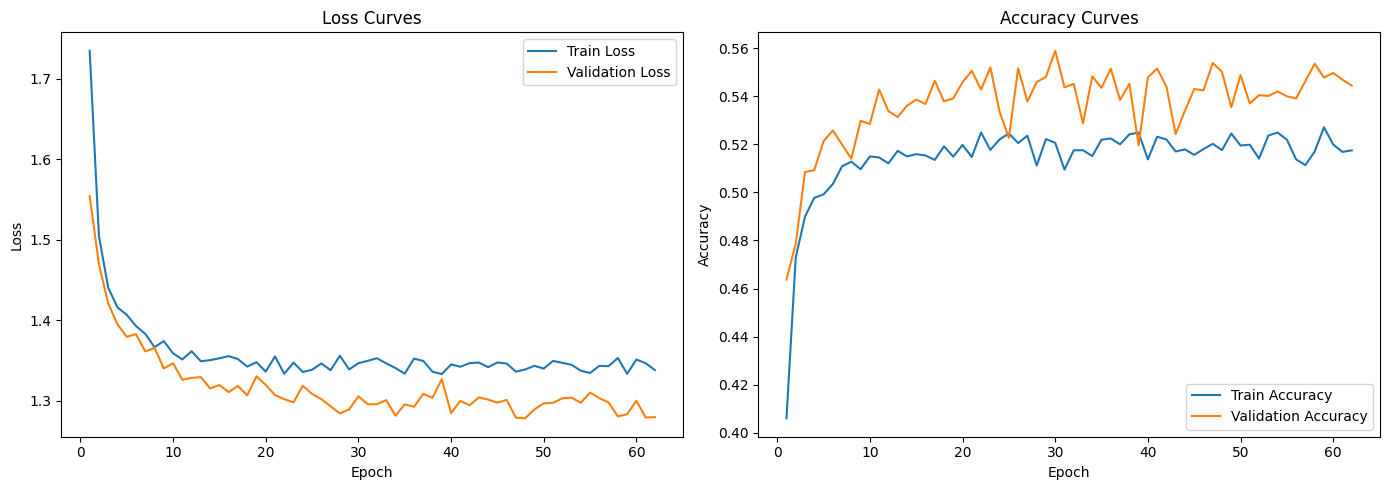

In [14]:
plot_acc_loss_curves(results=resnet50_results,validation=True)

In [15]:
save_model(model=ResNet50,model_name="Resnet50_62_epochs_trainable_classifier_early_stopper.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_62_epochs_trainable_classifier_early_stopper.pth


In [16]:
test_results = test_model(model=ResNet50,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5259
Test loss : 1.3268


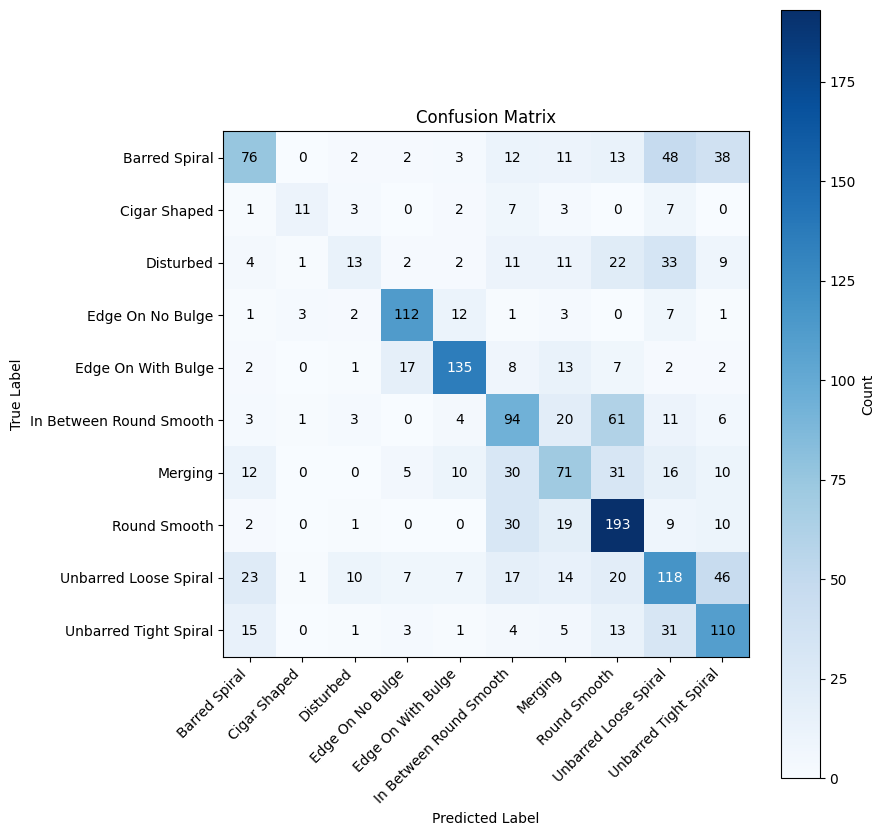

In [17]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

### Training ResNet50 on balanced dataset

In [32]:
ResNet50, resnet50_eval_transforms = resnet50(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet50.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [33]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [34]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet50_eval_transforms,
                                                                        batch_size=BATCH_SIZE)


In [35]:
resnet50_results,best_epoch = train(model=ResNet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1167 | train_acc: 0.2551 | test_loss: 1.9668 | test_acc: 0.3682
Epoch: 2 | train_loss: 1.8517 | train_acc: 0.3807 | test_loss: 1.8125 | test_acc: 0.3979
Epoch: 3 | train_loss: 1.7331 | train_acc: 0.4126 | test_loss: 1.7560 | test_acc: 0.4187
Epoch: 4 | train_loss: 1.6623 | train_acc: 0.4277 | test_loss: 1.6932 | test_acc: 0.4277
Epoch: 5 | train_loss: 1.6318 | train_acc: 0.4340 | test_loss: 1.6749 | test_acc: 0.4485
Epoch: 6 | train_loss: 1.5948 | train_acc: 0.4375 | test_loss: 1.6381 | test_acc: 0.4625
Epoch: 7 | train_loss: 1.5481 | train_acc: 0.4711 | test_loss: 1.6172 | test_acc: 0.4524
Epoch: 8 | train_loss: 1.5283 | train_acc: 0.4563 | test_loss: 1.5960 | test_acc: 0.4634
Epoch: 9 | train_loss: 1.5252 | train_acc: 0.4674 | test_loss: 1.6024 | test_acc: 0.4640
Epoch: 10 | train_loss: 1.4865 | train_acc: 0.4772 | test_loss: 1.5834 | test_acc: 0.4685
Epoch: 11 | train_loss: 1.4896 | train_acc: 0.4795 | test_loss: 1.5664 | test_acc: 0.4655
Epoch: 12 | train_l

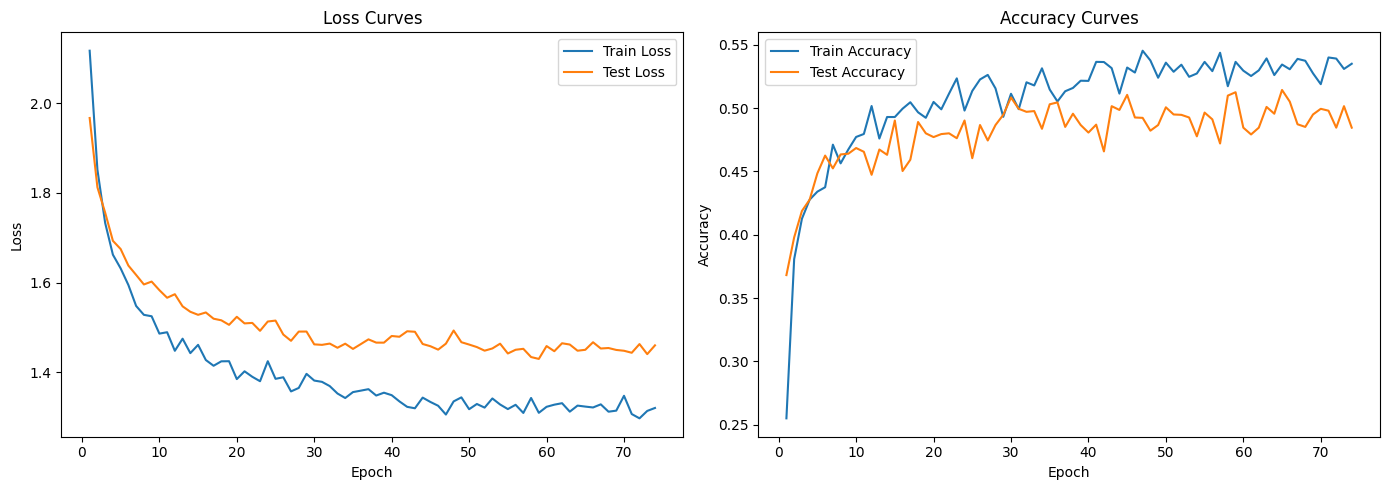

In [36]:
plot_acc_loss_curves(results=resnet50_results,validation=False)

In [39]:
save_model(model=ResNet50,model_name=f"Resnet50_74_epochs_trainable_classifier_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet50/Resnet50_74_epochs_trainable_classifier_early_stopping_balanced_dataset.pth


#### Evaluating ResNet50 on balanced test dataset

In [40]:
balanced_test_results = test_model(model=ResNet50,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4833
Test loss : 1.4588


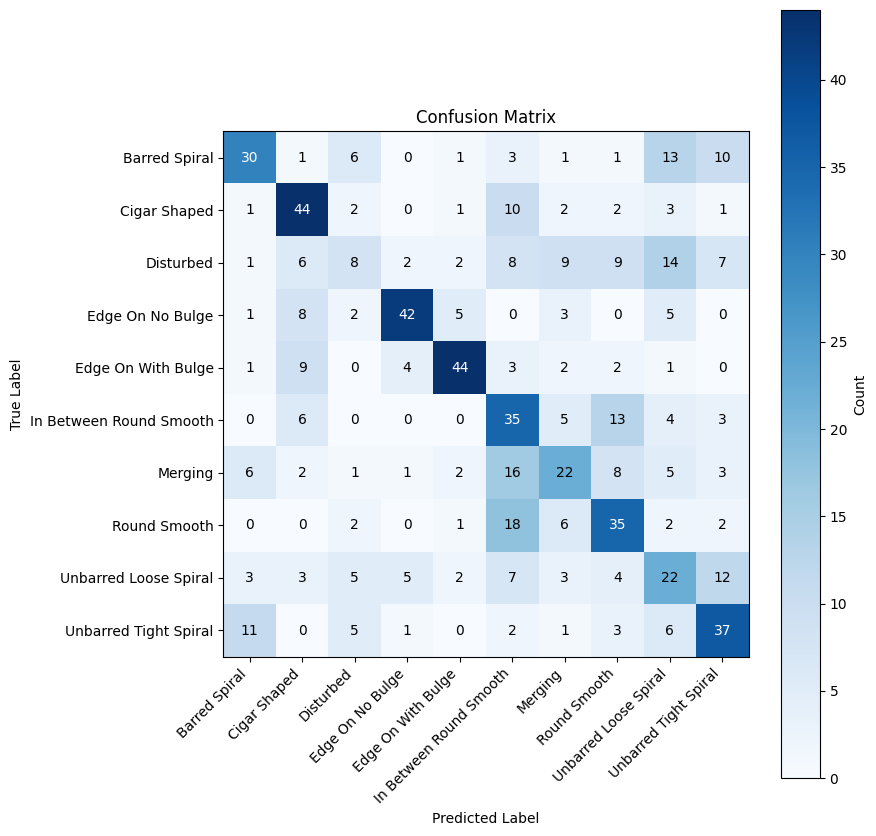

In [41]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet50 on unbalanced test dataset

In [42]:
test_results = test_model(model=ResNet50, #Test results on unbalanced test dataset
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4752
Test loss : 1.4446


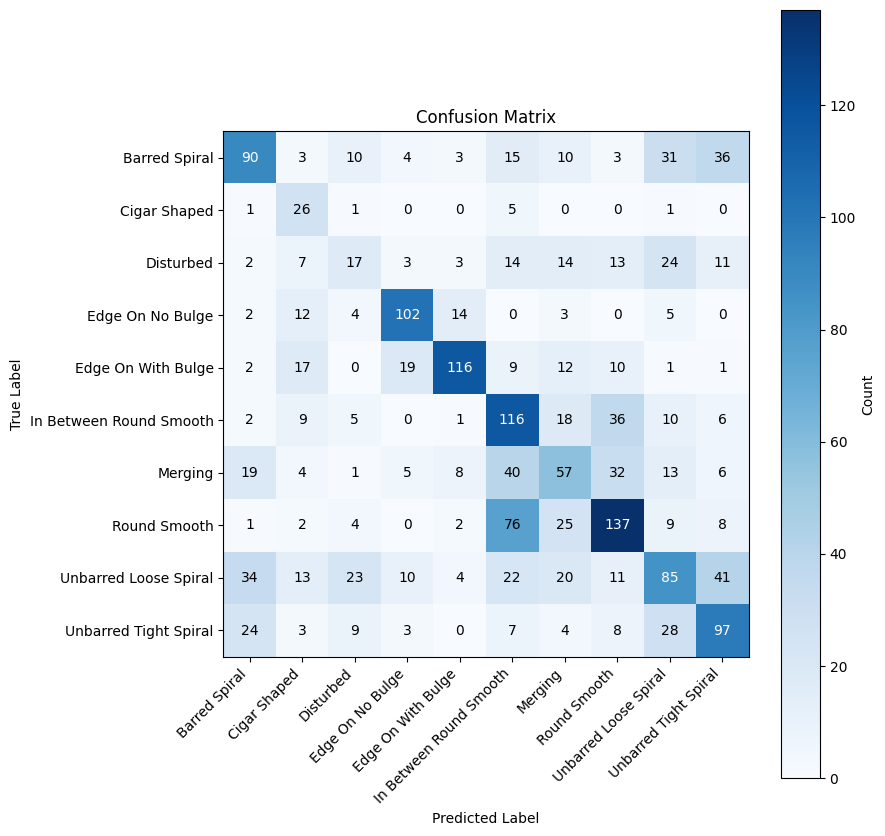

In [43]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## ResNet-26

In [5]:
ResNet26, resnet26_eval_transforms = resnet26(num_classes=10)

In [6]:
resnet26_eval_transforms

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [7]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [8]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [9]:
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
resnet26_results,best_epoch = train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5293 | train_acc: 0.4550 | val_loss: 1.4786 | val_acc: 0.4853
Epoch: 2 | train_loss: 1.3486 | train_acc: 0.5151 | val_loss: 1.4154 | val_acc: 0.4904
Epoch: 3 | train_loss: 1.3174 | train_acc: 0.5326 | val_loss: 1.3940 | val_acc: 0.5122
Epoch: 4 | train_loss: 1.3045 | train_acc: 0.5283 | val_loss: 1.3723 | val_acc: 0.5069
Epoch: 5 | train_loss: 1.2933 | train_acc: 0.5356 | val_loss: 1.4129 | val_acc: 0.4926
Epoch: 6 | train_loss: 1.2870 | train_acc: 0.5334 | val_loss: 1.3716 | val_acc: 0.5128
Epoch: 7 | train_loss: 1.2822 | train_acc: 0.5408 | val_loss: 1.3757 | val_acc: 0.5125
Epoch: 8 | train_loss: 1.2721 | train_acc: 0.5460 | val_loss: 1.3995 | val_acc: 0.5090
Epoch: 9 | train_loss: 1.2660 | train_acc: 0.5459 | val_loss: 1.3913 | val_acc: 0.4988
Epoch: 10 | train_loss: 1.2715 | train_acc: 0.5463 | val_loss: 1.3440 | val_acc: 0.5194
Epoch: 11 | train_loss: 1.2688 | train_acc: 0.5453 | val_loss: 1.3468 | val_acc: 0.5171
Epoch: 12 | train_loss: 1.2498 | train_ac

In [19]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 33 epochs


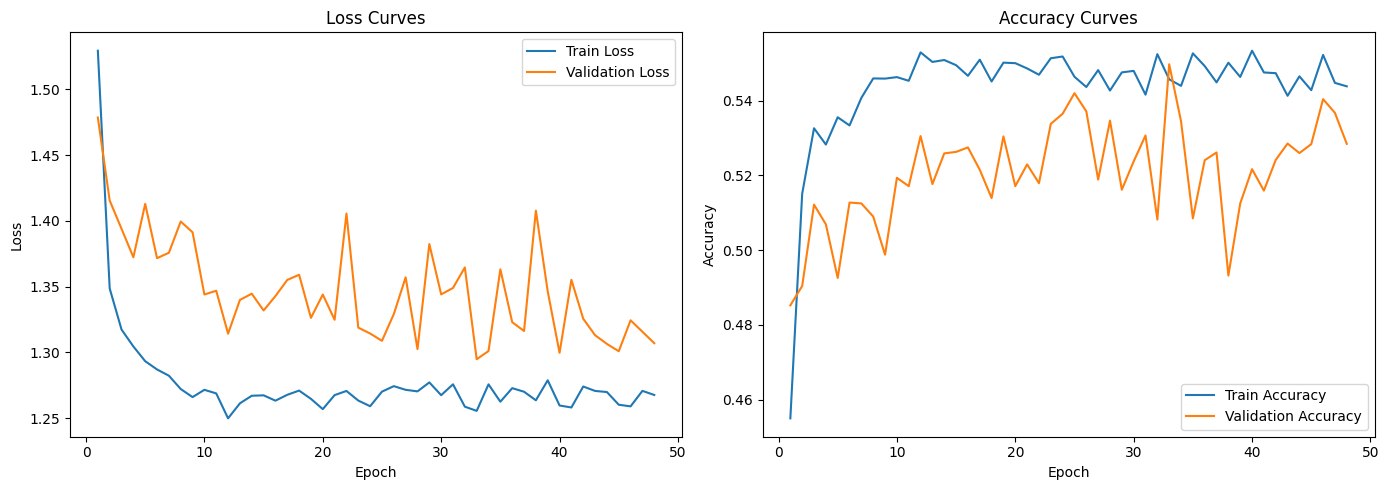

In [14]:
plot_acc_loss_curves(results=resnet26_results,validation=True)

In [15]:
test_results = test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5169
Test loss : 1.3493


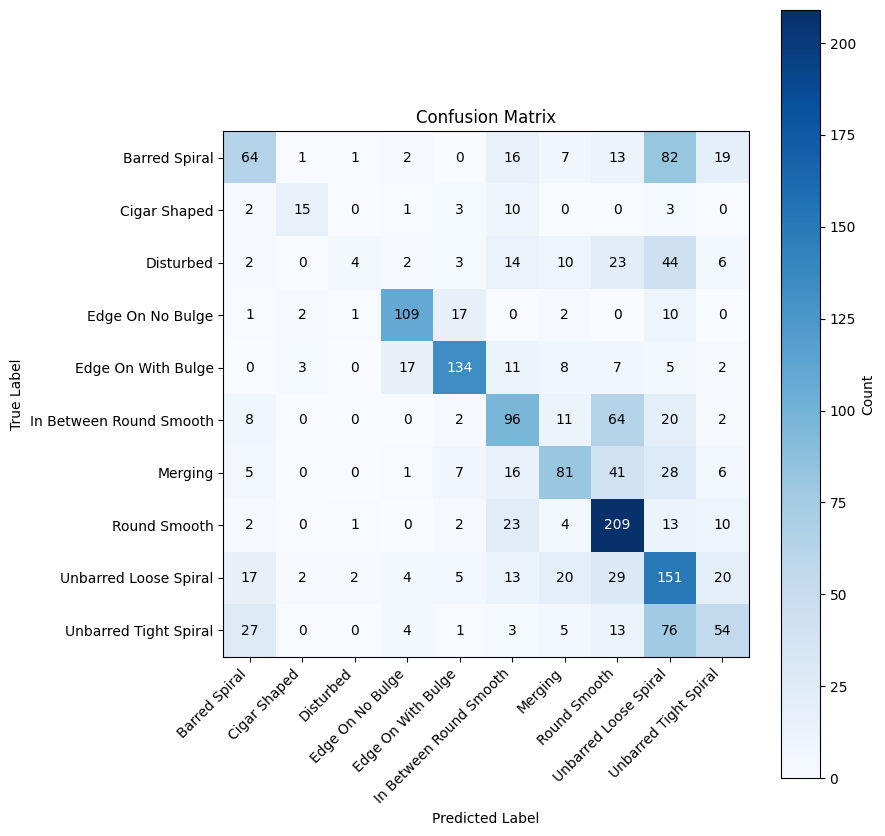

In [16]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [18]:
save_model(model=ResNet26,model_name=f"Resnet26_{best_epoch}_epochs_trainable_classifier_early_stopping.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_33_epochs_trainable_classifier_early_stopping.pth


### Training ResNet26 on balanced dataset

In [26]:
ResNet26, resnet26_eval_transforms = resnet26(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet26.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [27]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet26_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [29]:
resnet26_results, best_epoch = train(model=ResNet26,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9026 | train_acc: 0.3331 | test_loss: 1.7877 | test_acc: 0.4098
Epoch: 2 | train_loss: 1.5577 | train_acc: 0.4505 | test_loss: 1.6744 | test_acc: 0.4241
Epoch: 3 | train_loss: 1.4793 | train_acc: 0.4746 | test_loss: 1.6508 | test_acc: 0.4021
Epoch: 4 | train_loss: 1.4045 | train_acc: 0.4968 | test_loss: 1.5808 | test_acc: 0.4503
Epoch: 5 | train_loss: 1.3989 | train_acc: 0.4996 | test_loss: 1.5914 | test_acc: 0.4360
Epoch: 6 | train_loss: 1.3302 | train_acc: 0.5331 | test_loss: 1.5528 | test_acc: 0.4497
Epoch: 7 | train_loss: 1.3279 | train_acc: 0.5304 | test_loss: 1.5382 | test_acc: 0.4509
Epoch: 8 | train_loss: 1.3309 | train_acc: 0.5249 | test_loss: 1.5369 | test_acc: 0.4649
Epoch: 9 | train_loss: 1.2983 | train_acc: 0.5427 | test_loss: 1.5439 | test_acc: 0.4574
Epoch: 10 | train_loss: 1.2891 | train_acc: 0.5428 | test_loss: 1.5448 | test_acc: 0.4759
Epoch: 11 | train_loss: 1.2784 | train_acc: 0.5525 | test_loss: 1.5307 | test_acc: 0.4488
Epoch: 12 | train_l

In [30]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 74 epochs


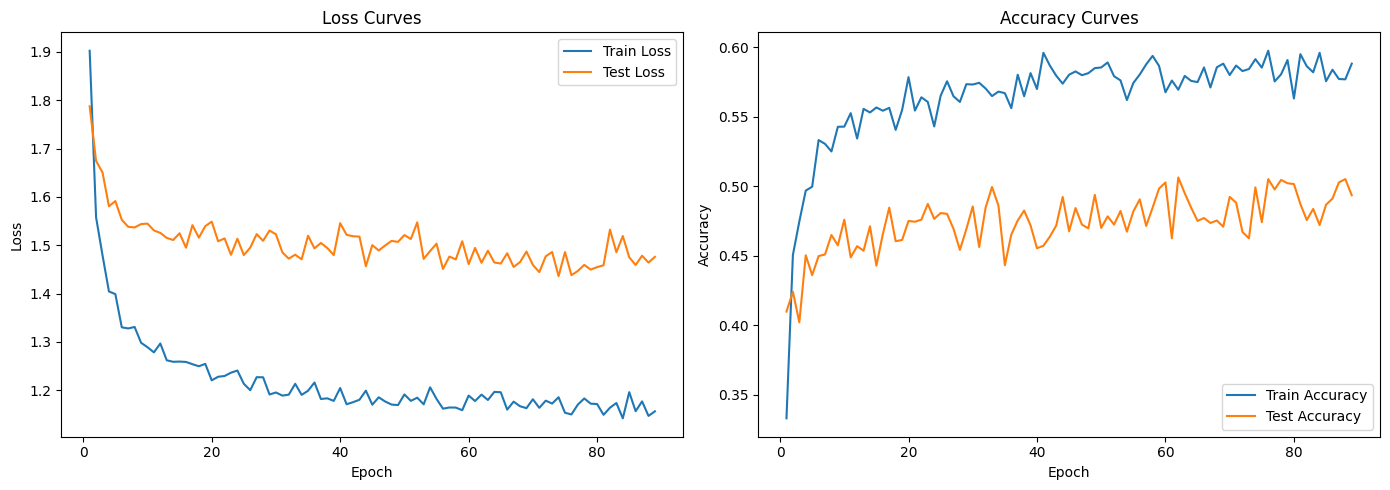

In [31]:
plot_acc_loss_curves(results=resnet26_results,validation=False)

In [32]:
save_model(model=ResNet26,model_name=f"Resnet26_{best_epoch}_epochs_trainable_classifier_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet26/Resnet26_74_epochs_trainable_classifier_early_stopping_balanced_dataset.pth


#### Evaluating ResNet26 on balanced test daataset

In [33]:
balanced_test_results = test_model(model=ResNet26,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4924
Test loss : 1.4766


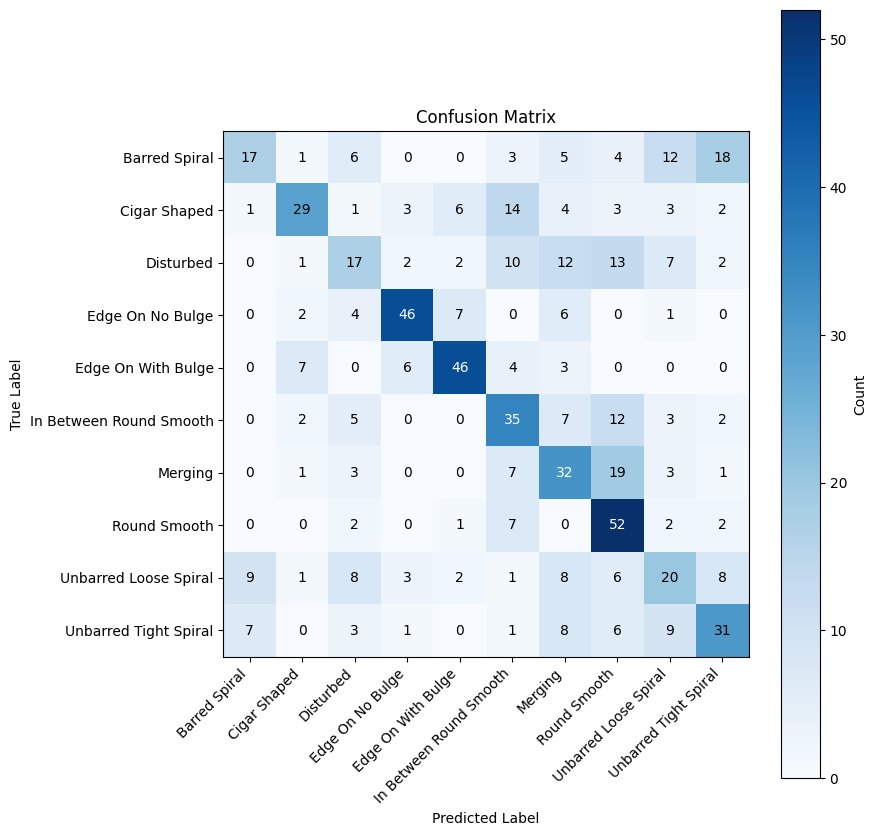

In [34]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet26 on unbalanced test daataset

In [35]:
test_results = test_model(model=ResNet26,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4899
Test loss : 1.4552


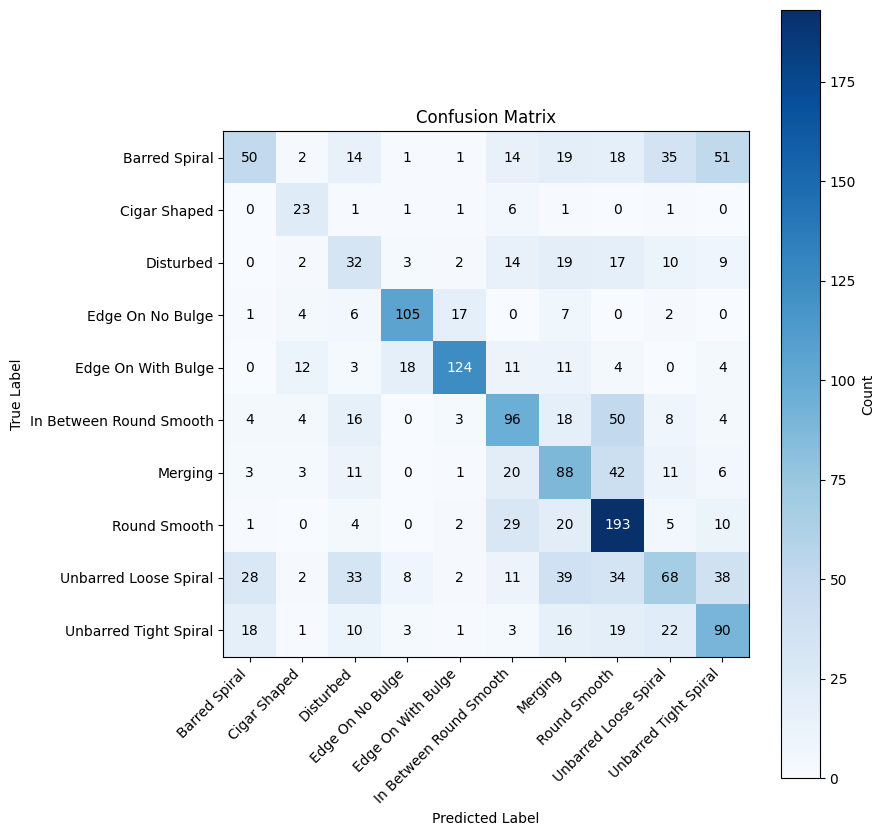

In [36]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)
#Confusion matrix for unbalanced test dataset

<br>
<br>
<br>

## ResNet18

In [42]:
ResNet18, resnet18_eval_transforms = resnet18(num_classes=10)

In [43]:
resnet18_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [44]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [45]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet18_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [46]:
optimizer = torch.optim.Adam(params=ResNet18.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [47]:
resnet18_results, best_epoch = train(model=ResNet18,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device,
                      epochs=EPOCHS*3,
                      train_dataloader=train_loader,
                      test_dataloader=val_loader,
                      validation=True,
                      early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7303 | train_acc: 0.3806 | val_loss: 1.6039 | val_acc: 0.4279
Epoch: 2 | train_loss: 1.5164 | train_acc: 0.4552 | val_loss: 1.5395 | val_acc: 0.4675
Epoch: 3 | train_loss: 1.4793 | train_acc: 0.4672 | val_loss: 1.4914 | val_acc: 0.4854
Epoch: 4 | train_loss: 1.4600 | train_acc: 0.4734 | val_loss: 1.4695 | val_acc: 0.4766
Epoch: 5 | train_loss: 1.4562 | train_acc: 0.4736 | val_loss: 1.4864 | val_acc: 0.4743
Epoch: 6 | train_loss: 1.4438 | train_acc: 0.4830 | val_loss: 1.4324 | val_acc: 0.4753
Epoch: 7 | train_loss: 1.4459 | train_acc: 0.4786 | val_loss: 1.4590 | val_acc: 0.4841
Epoch: 8 | train_loss: 1.4404 | train_acc: 0.4898 | val_loss: 1.4328 | val_acc: 0.4916
Epoch: 9 | train_loss: 1.4224 | train_acc: 0.4905 | val_loss: 1.4627 | val_acc: 0.4859
Epoch: 10 | train_loss: 1.4343 | train_acc: 0.4785 | val_loss: 1.4722 | val_acc: 0.4640
Epoch: 11 | train_loss: 1.4321 | train_acc: 0.4864 | val_loss: 1.4255 | val_acc: 0.4983
Epoch: 12 | train_loss: 1.4268 | train_ac

In [48]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 29 epochs


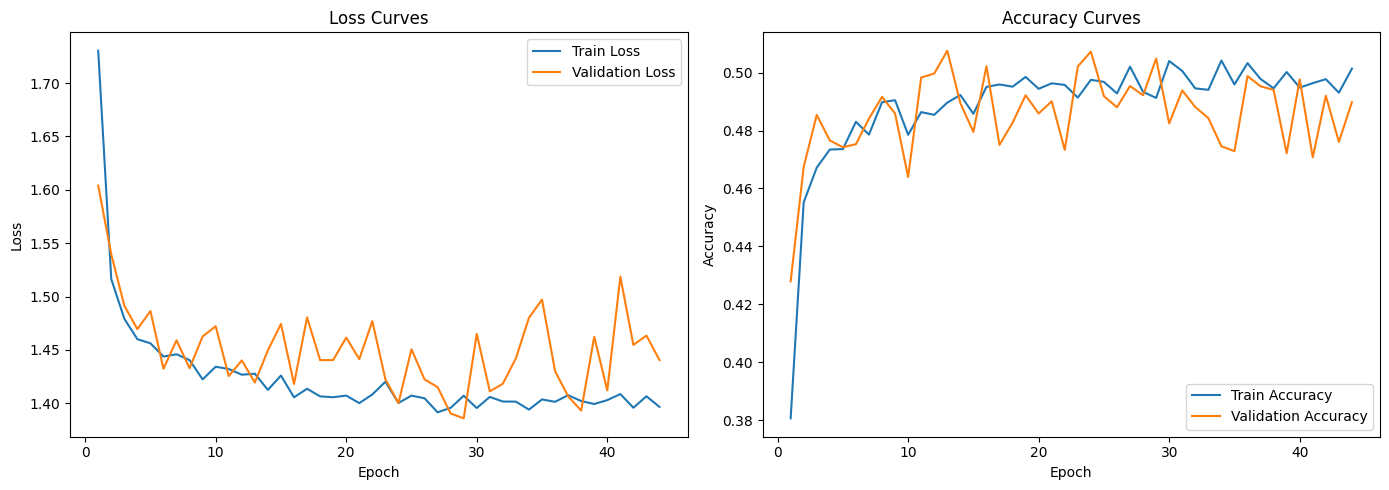

In [49]:
plot_acc_loss_curves(results=resnet18_results,validation=True)

In [50]:
test_results = test_model(model=ResNet18,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4707
Test loss : 1.4653


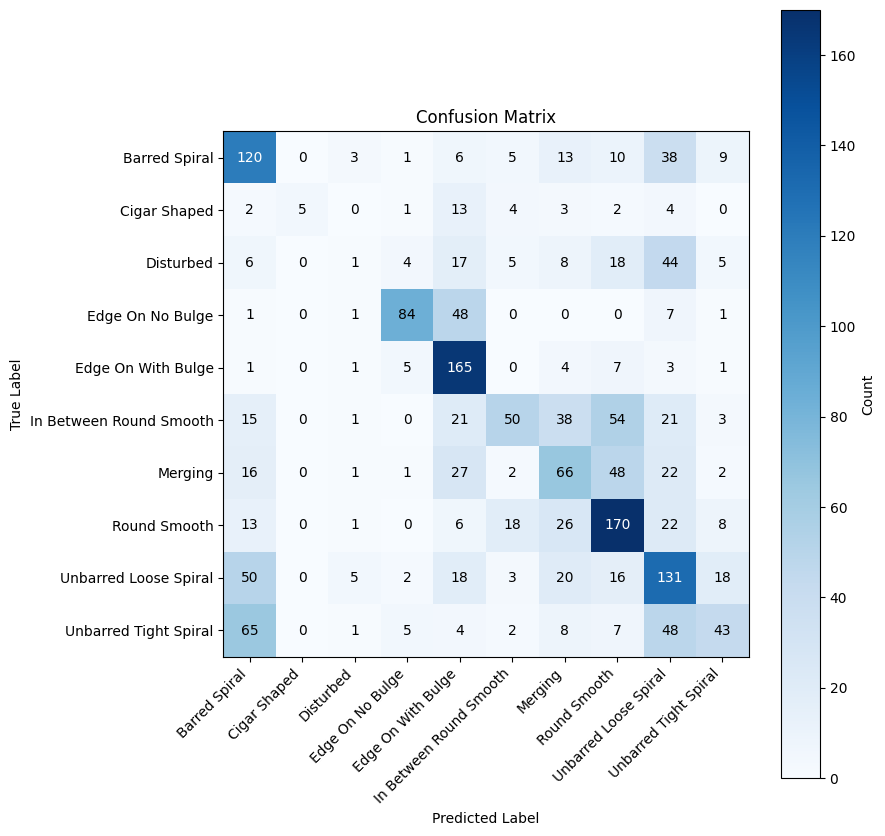

In [51]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [53]:
best_epoch

29

In [52]:
save_model(model=ResNet18,model_name=f"Resnet18_{best_epoch}_epochs_trainable_classifier_early_stopping.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet18/Resnet18_29_epochs_trainable_classifier_early_stopping.pth


<br>

### Training ResNet18 on balanced dataset

In [54]:
ResNet18, resnet18_eval_transforms = resnet18(num_classes=10)
optimizer = torch.optim.Adam(params=ResNet18.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [55]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=resnet18_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [57]:
resnet18_results, best_epoch = train(model=ResNet18,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device,
                      epochs=EPOCHS*3,
                      train_dataloader=balanced_train_loader,
                      test_dataloader=balanced_test_loader,
                      validation=False,
                      early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1091 | train_acc: 0.2339 | test_loss: 1.9348 | test_acc: 0.3039
Epoch: 2 | train_loss: 1.8039 | train_acc: 0.3553 | test_loss: 1.7575 | test_acc: 0.3777
Epoch: 3 | train_loss: 1.6876 | train_acc: 0.3948 | test_loss: 1.7147 | test_acc: 0.3839
Epoch: 4 | train_loss: 1.6301 | train_acc: 0.4062 | test_loss: 1.6514 | test_acc: 0.3908
Epoch: 5 | train_loss: 1.5746 | train_acc: 0.4359 | test_loss: 1.6330 | test_acc: 0.4051
Epoch: 6 | train_loss: 1.5678 | train_acc: 0.4381 | test_loss: 1.6446 | test_acc: 0.3890
Epoch: 7 | train_loss: 1.5367 | train_acc: 0.4452 | test_loss: 1.6331 | test_acc: 0.4068
Epoch: 8 | train_loss: 1.5301 | train_acc: 0.4462 | test_loss: 1.6178 | test_acc: 0.4068
Epoch: 9 | train_loss: 1.5065 | train_acc: 0.4467 | test_loss: 1.5903 | test_acc: 0.4330
Epoch: 10 | train_loss: 1.4787 | train_acc: 0.4629 | test_loss: 1.6005 | test_acc: 0.4315
Epoch: 11 | train_loss: 1.4881 | train_acc: 0.4700 | test_loss: 1.5952 | test_acc: 0.4158
Epoch: 12 | train_l

In [59]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 23 epochs


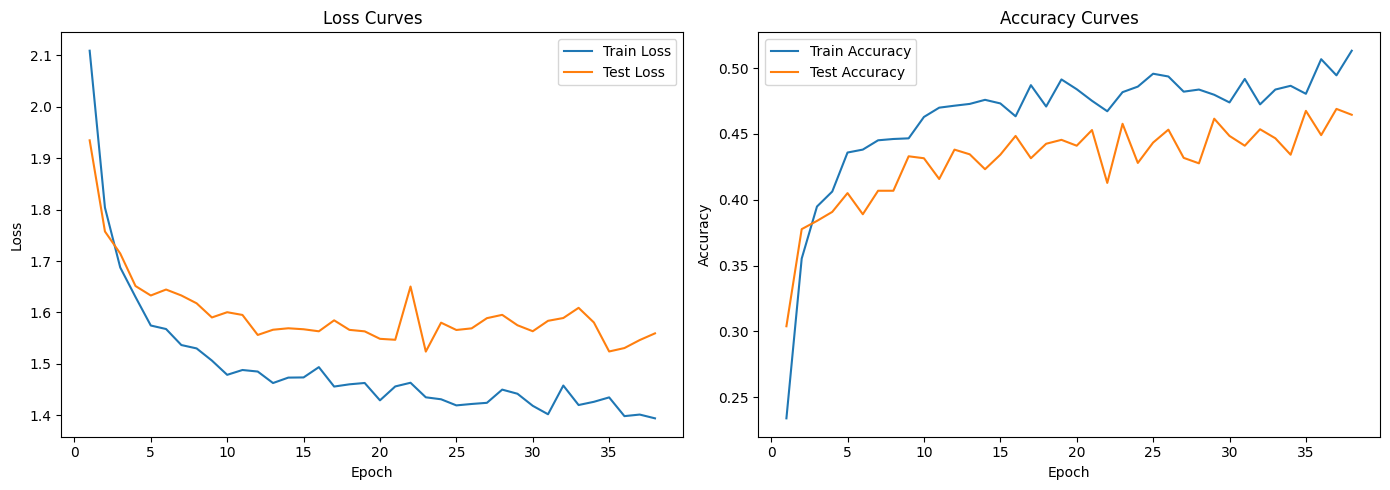

In [58]:
plot_acc_loss_curves(results=resnet18_results,validation=False)

In [60]:
save_model(model=ResNet18,model_name=f"Resnet18_{best_epoch}_epochs_trainable_classifier_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/resnet18/Resnet18_23_epochs_trainable_classifier_early_stopping_balanced_dataset.pth


<br>

#### Evaluating ResNet18 (trained on balanced dataset) on balanced test dataset

In [61]:
balanced_test_results = test_model(model=ResNet18,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.4667
Test loss : 1.5569


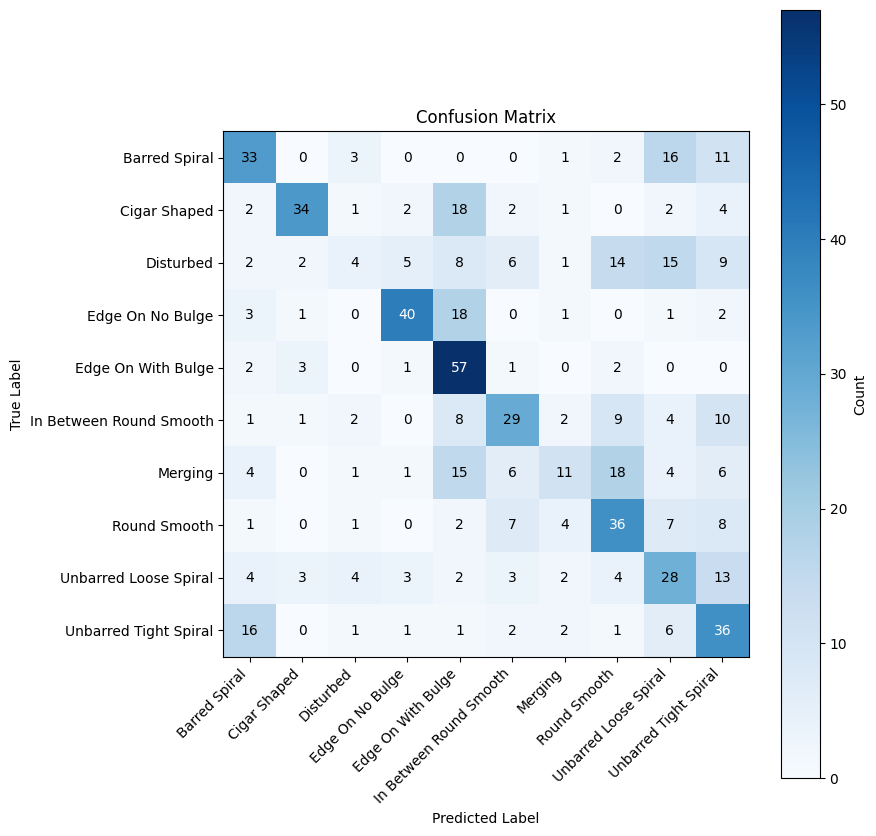

In [62]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating ResNet18 (trained on balanced dataset) on unbalanced test dataset

In [63]:
test_results = test_model(model=ResNet18,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.4504
Test loss : 1.5166


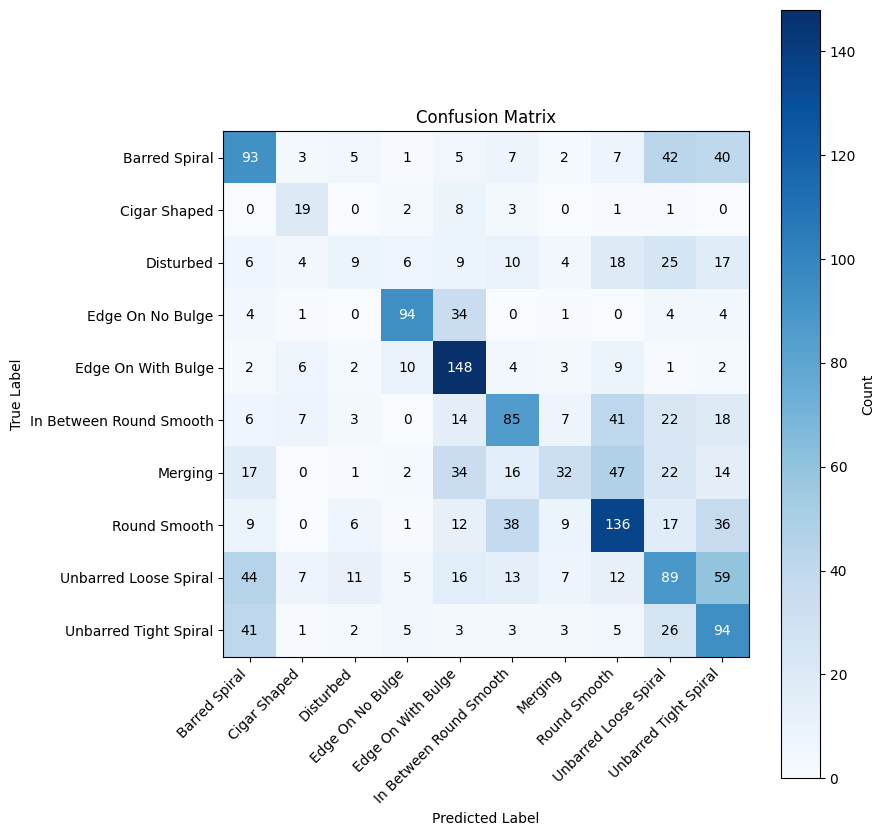

In [64]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## VGG16

In [65]:
Vgg16, vgg16_eval_transforms = vgg16(num_classes=10)

In [66]:
vgg16_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [67]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [69]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg16_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [70]:
optimizer = torch.optim.Adam(params=Vgg16.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [71]:
vgg16_results, best_epoch = train(model=Vgg16,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6579 | train_acc: 0.3989 | val_loss: 1.3889 | val_acc: 0.5108
Epoch: 2 | train_loss: 1.4149 | train_acc: 0.4737 | val_loss: 1.2563 | val_acc: 0.5526
Epoch: 3 | train_loss: 1.3593 | train_acc: 0.5040 | val_loss: 1.2689 | val_acc: 0.5408
Epoch: 4 | train_loss: 1.3148 | train_acc: 0.5216 | val_loss: 1.2063 | val_acc: 0.5655
Epoch: 5 | train_loss: 1.2775 | train_acc: 0.5315 | val_loss: 1.2020 | val_acc: 0.5851
Epoch: 6 | train_loss: 1.2628 | train_acc: 0.5471 | val_loss: 1.1957 | val_acc: 0.5693
Epoch: 7 | train_loss: 1.2399 | train_acc: 0.5483 | val_loss: 1.1720 | val_acc: 0.5930
Epoch: 8 | train_loss: 1.2171 | train_acc: 0.5619 | val_loss: 1.1559 | val_acc: 0.5980
Epoch: 9 | train_loss: 1.2119 | train_acc: 0.5644 | val_loss: 1.1568 | val_acc: 0.5862
Epoch: 10 | train_loss: 1.1998 | train_acc: 0.5705 | val_loss: 1.1616 | val_acc: 0.5855
Epoch: 11 | train_loss: 1.1829 | train_acc: 0.5755 | val_loss: 1.1318 | val_acc: 0.6177
Epoch: 12 | train_loss: 1.1870 | train_ac

In [72]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 25 epochs


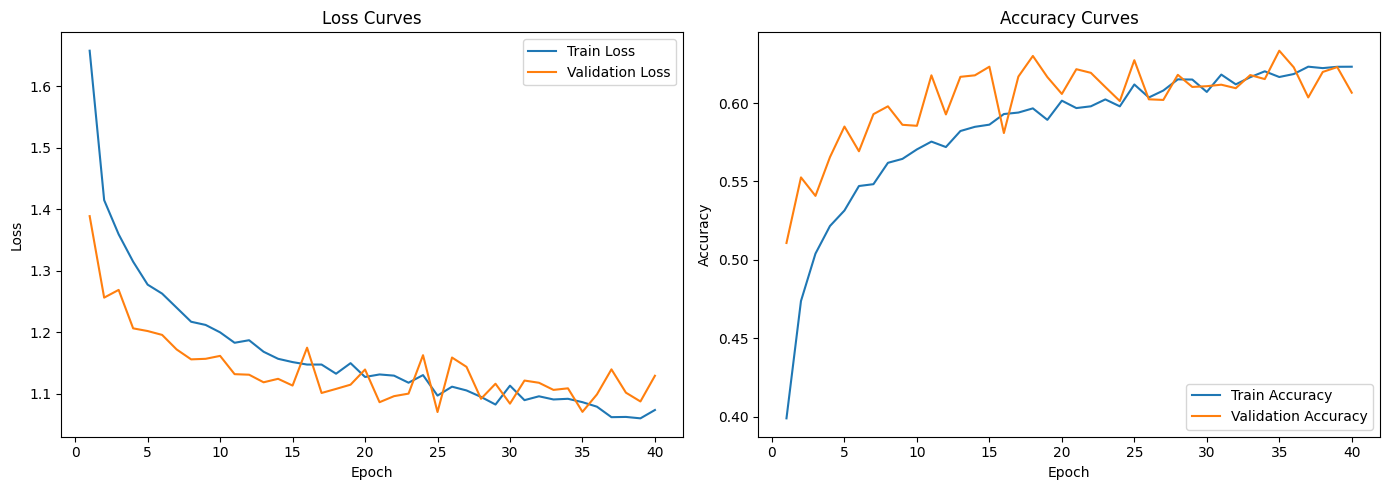

In [73]:
plot_acc_loss_curves(results=vgg16_results,validation=True)

In [74]:
test_results = test_model(model=Vgg16,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5874
Test loss : 1.1584


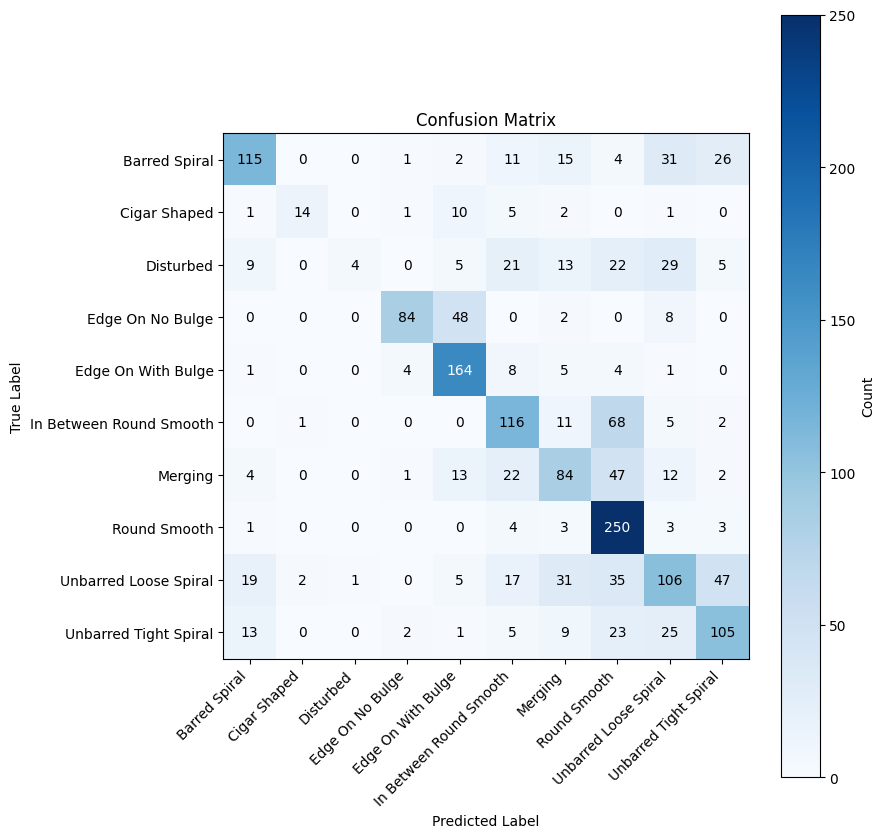

In [75]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [76]:
save_model(model=ResNet26,model_name=f"VGG16_{best_epoch}_epochs_trainable_classifier_early_stopping.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg16/VGG16_25_epochs_trainable_classifier_early_stopping.pth


<br>

### Training VGG16 on balanced dataset

In [77]:
Vgg16, vgg16_eval_transforms = vgg16(num_classes=10)
optimizer = torch.optim.Adam(params=Vgg16.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [78]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [ ]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg16_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [81]:
vgg16_results, best_epoch = train(model=Vgg16,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1432 | train_acc: 0.2781 | test_loss: 1.6202 | test_acc: 0.3943
Epoch: 2 | train_loss: 1.6208 | train_acc: 0.3764 | test_loss: 1.5642 | test_acc: 0.4131
Epoch: 3 | train_loss: 1.5158 | train_acc: 0.4211 | test_loss: 1.4592 | test_acc: 0.4720
Epoch: 4 | train_loss: 1.4724 | train_acc: 0.4452 | test_loss: 1.4194 | test_acc: 0.4539
Epoch: 5 | train_loss: 1.4264 | train_acc: 0.4675 | test_loss: 1.3993 | test_acc: 0.4753
Epoch: 6 | train_loss: 1.3972 | train_acc: 0.4680 | test_loss: 1.4152 | test_acc: 0.4753
Epoch: 7 | train_loss: 1.3794 | train_acc: 0.4942 | test_loss: 1.3755 | test_acc: 0.4952
Epoch: 8 | train_loss: 1.3425 | train_acc: 0.5022 | test_loss: 1.3741 | test_acc: 0.5021
Epoch: 9 | train_loss: 1.3174 | train_acc: 0.5115 | test_loss: 1.3381 | test_acc: 0.5107
Epoch: 10 | train_loss: 1.2637 | train_acc: 0.5275 | test_loss: 1.3724 | test_acc: 0.4720
Epoch: 11 | train_loss: 1.2994 | train_acc: 0.5181 | test_loss: 1.4300 | test_acc: 0.4798
Epoch: 12 | train_l

In [82]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 44 epochs


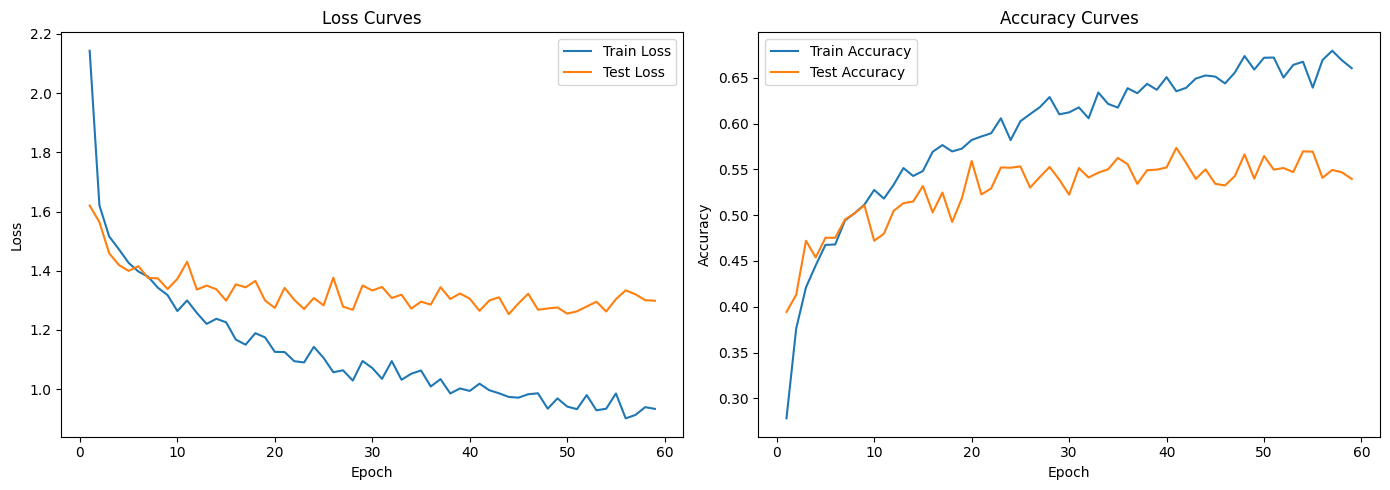

In [83]:
plot_acc_loss_curves(results=vgg16_results,validation=False)

In [84]:
save_model(model=Vgg16,model_name=f"VGG16_{best_epoch}_epochs_trainable_classifier_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg16/VGG16_44_epochs_trainable_classifier_early_stopping_balanced_dataset.pth


<br>

#### Evaluating VGG16 on balanced test dataset

In [85]:
balanced_test_results = test_model(model=Vgg16,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.5394
Test loss : 1.2986


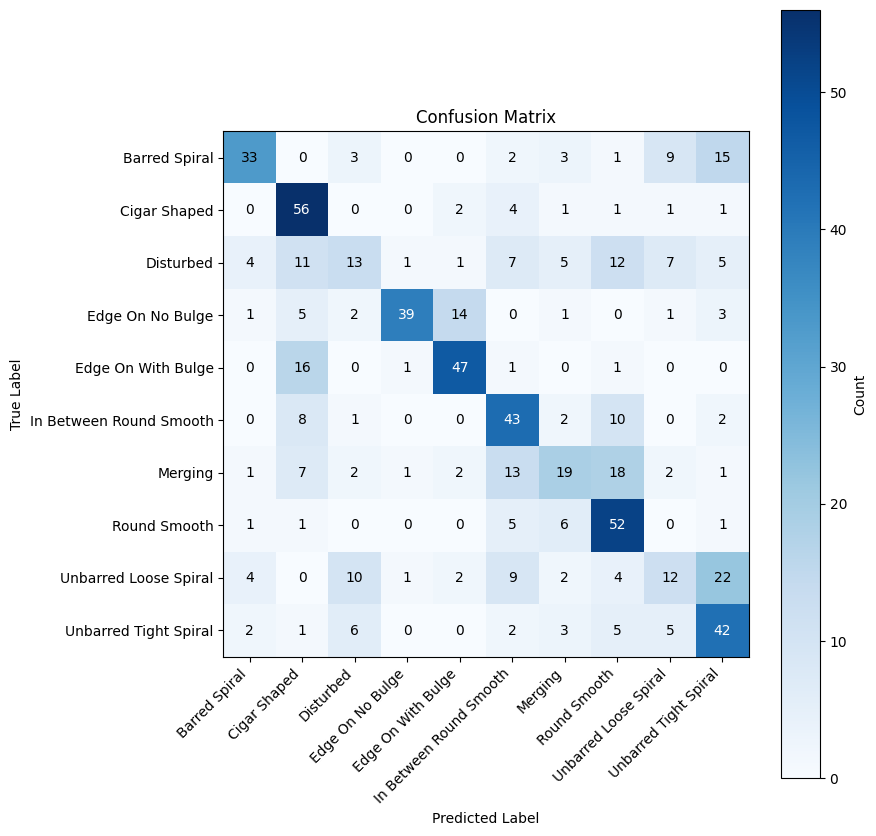

In [86]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

#### Evaluating VGG16 on unbalanced test dataset

In [87]:
test_results = test_model(model=Vgg16,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5349
Test loss : 1.3320


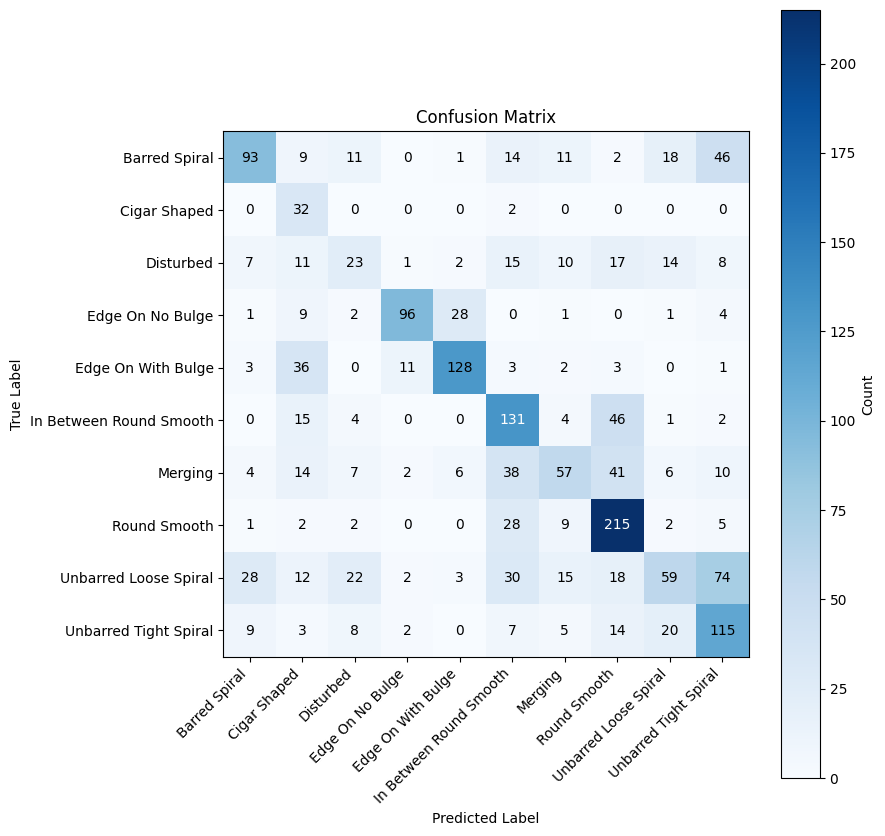

In [88]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## VGG19

In [7]:
Vgg19, vgg19_eval_transforms = vgg19(num_classes=10)

In [8]:
vgg19_eval_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [10]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg19_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [11]:
optimizer = torch.optim.Adam(params=Vgg19.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
vgg19_results, best_epoch = train(model=Vgg19,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8451 | train_acc: 0.3638 | val_loss: 1.4412 | val_acc: 0.4340
Epoch: 2 | train_loss: 1.5562 | train_acc: 0.4146 | val_loss: 1.3635 | val_acc: 0.5006
Epoch: 3 | train_loss: 1.5124 | train_acc: 0.4304 | val_loss: 1.3777 | val_acc: 0.5028
Epoch: 4 | train_loss: 1.4817 | train_acc: 0.4444 | val_loss: 1.3886 | val_acc: 0.4983
Epoch: 5 | train_loss: 1.4692 | train_acc: 0.4563 | val_loss: 1.2411 | val_acc: 0.5411
Epoch: 6 | train_loss: 1.4335 | train_acc: 0.4672 | val_loss: 1.2260 | val_acc: 0.5552
Epoch: 7 | train_loss: 1.4153 | train_acc: 0.4840 | val_loss: 1.2444 | val_acc: 0.5519
Epoch: 8 | train_loss: 1.4082 | train_acc: 0.4837 | val_loss: 1.2444 | val_acc: 0.5361
Epoch: 9 | train_loss: 1.3962 | train_acc: 0.4837 | val_loss: 1.2027 | val_acc: 0.5620
Epoch: 10 | train_loss: 1.3932 | train_acc: 0.4845 | val_loss: 1.2576 | val_acc: 0.5287
Epoch: 11 | train_loss: 1.3800 | train_acc: 0.4978 | val_loss: 1.2194 | val_acc: 0.5468
Epoch: 12 | train_loss: 1.3744 | train_ac

In [13]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 60 epochs


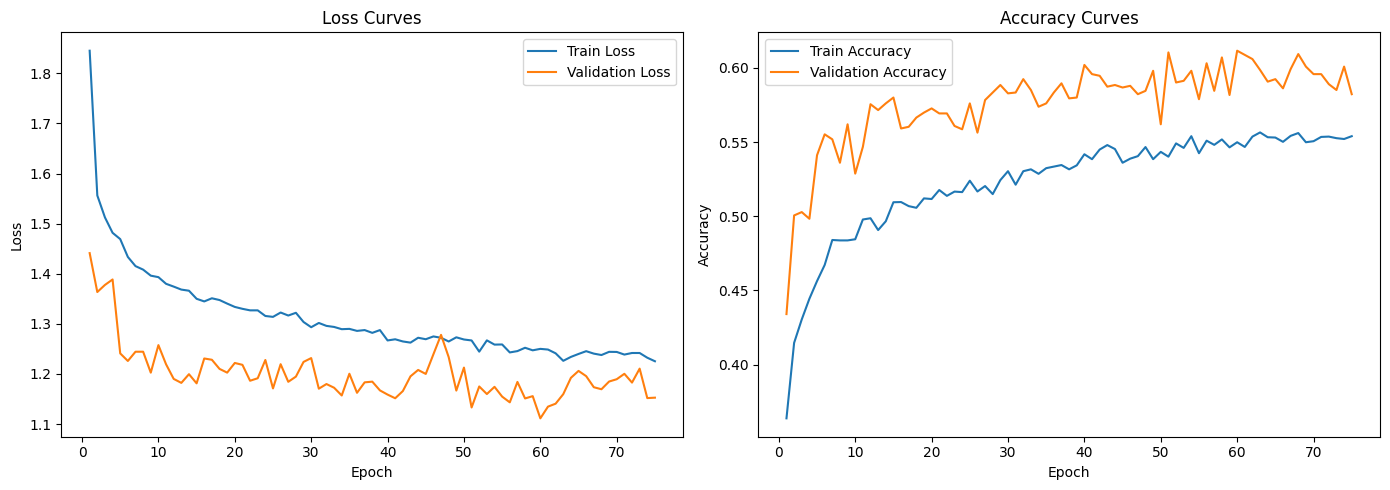

In [14]:
plot_acc_loss_curves(results=vgg19_results,validation=True)

In [15]:
test_results = test_model(model=Vgg19,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5688
Test loss : 1.2092


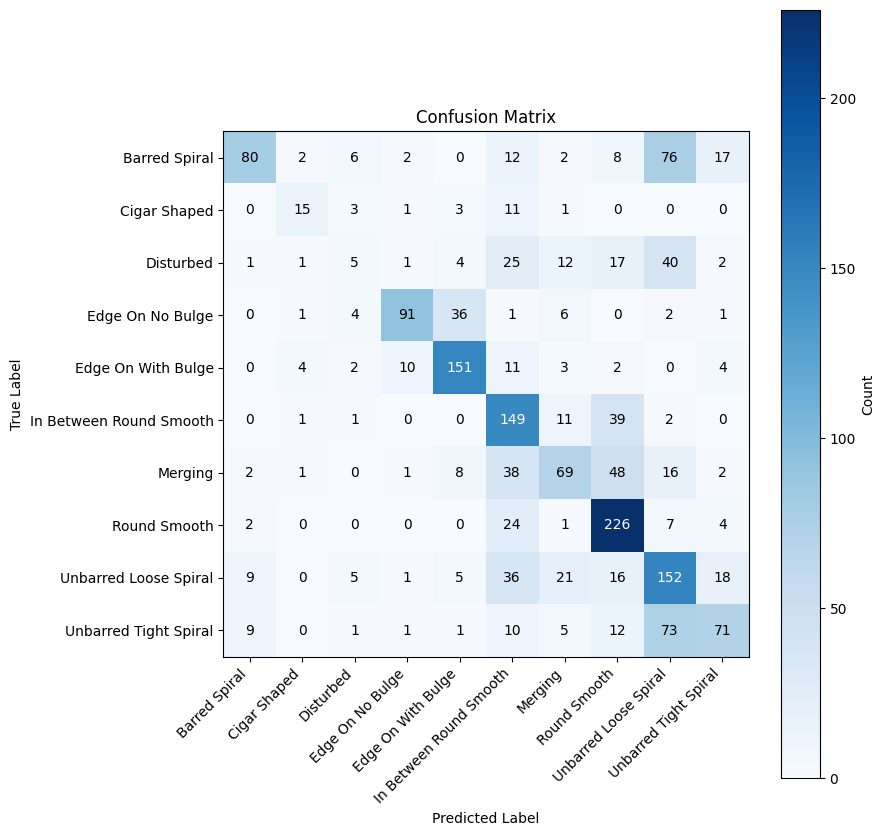

In [16]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

In [18]:
save_model(model=Vgg19,model_name=f"VGG19_{best_epoch}_epochs_trainable_classifier_early_stopping.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/vgg19/VGG19_60_epochs_trainable_classifier_early_stopping.pth


<br>

#### Training VGG19 on balanced dataset

In [19]:
Vgg19, vgg19_eval_transforms = vgg19(num_classes=10)
optimizer = torch.optim.Adam(params=Vgg19.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [22]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=NUM_WORKERS,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=vgg19_eval_transforms,
                                                                        batch_size=BATCH_SIZE)

In [23]:
vgg19_results, best_epoch = train(model=Vgg19,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9412 | train_acc: 0.2713 | test_loss: 1.6339 | test_acc: 0.3955
Epoch: 2 | train_loss: 1.7254 | train_acc: 0.3425 | test_loss: 1.5596 | test_acc: 0.4045
Epoch: 3 | train_loss: 1.6140 | train_acc: 0.3869 | test_loss: 1.4851 | test_acc: 0.4439
Epoch: 4 | train_loss: 1.6026 | train_acc: 0.4045 | test_loss: 1.5022 | test_acc: 0.4364
Epoch: 5 | train_loss: 1.5796 | train_acc: 0.4067 | test_loss: 1.5250 | test_acc: 0.4439
Epoch: 6 | train_loss: 1.5727 | train_acc: 0.4116 | test_loss: 1.4749 | test_acc: 0.4636
Epoch: 7 | train_loss: 1.5174 | train_acc: 0.4321 | test_loss: 1.3983 | test_acc: 0.4758
Epoch: 8 | train_loss: 1.4976 | train_acc: 0.4351 | test_loss: 1.4060 | test_acc: 0.4879
Epoch: 9 | train_loss: 1.5061 | train_acc: 0.4429 | test_loss: 1.4846 | test_acc: 0.4576
Epoch: 10 | train_loss: 1.4654 | train_acc: 0.4407 | test_loss: 1.5270 | test_acc: 0.4409
Epoch: 11 | train_loss: 1.4685 | train_acc: 0.4440 | test_loss: 1.4504 | test_acc: 0.4667
Epoch: 12 | train_l

In [24]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 56 epochs


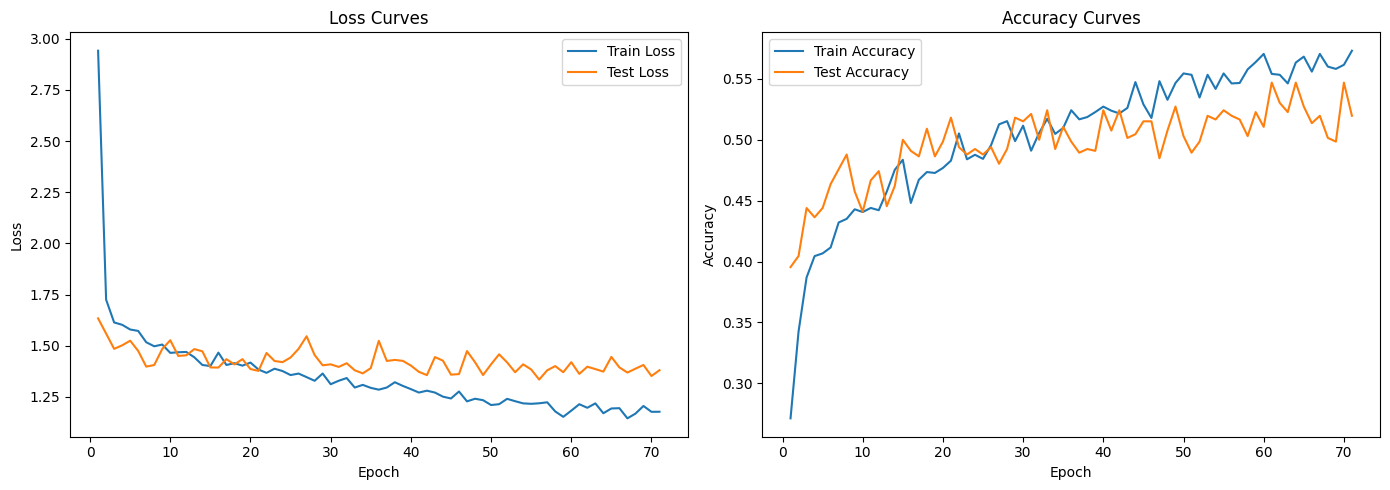

In [25]:
plot_acc_loss_curves(results=vgg19_results,validation=False)

<br>

#### Evaluating VGG19 on balanced test dataset

In [26]:
balanced_test_results = test_model(model=Vgg19,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.5197
Test loss : 1.3807


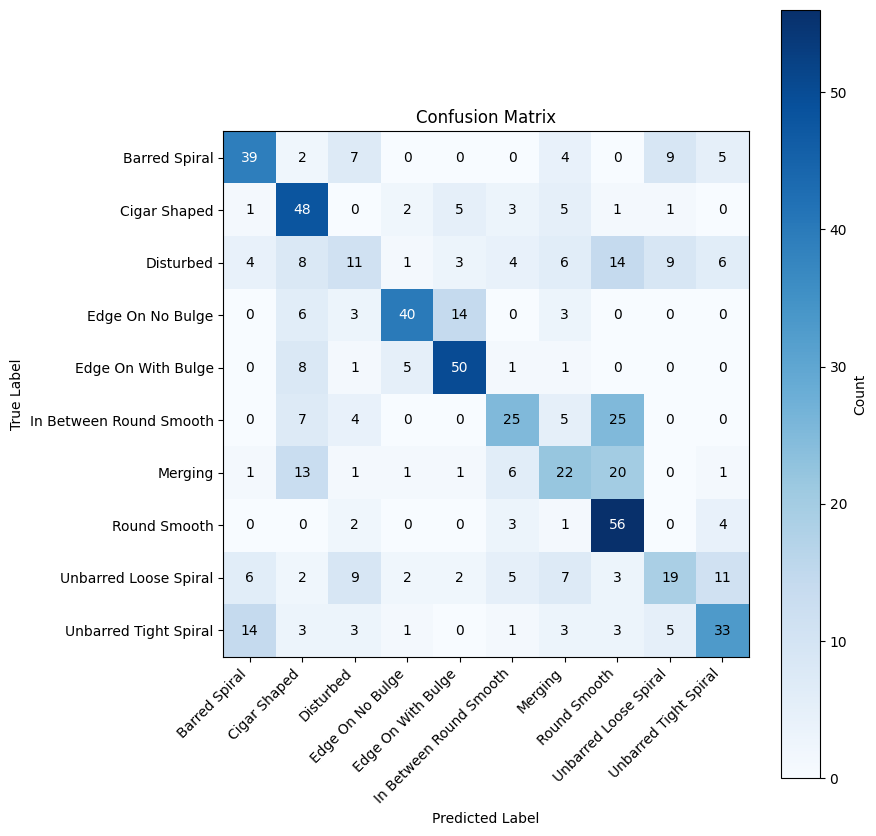

In [27]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

#### Evaluating VGG19 on balanced test dataset

In [28]:
est_results = test_model(model=Vgg19,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.5688
Test loss : 1.2092


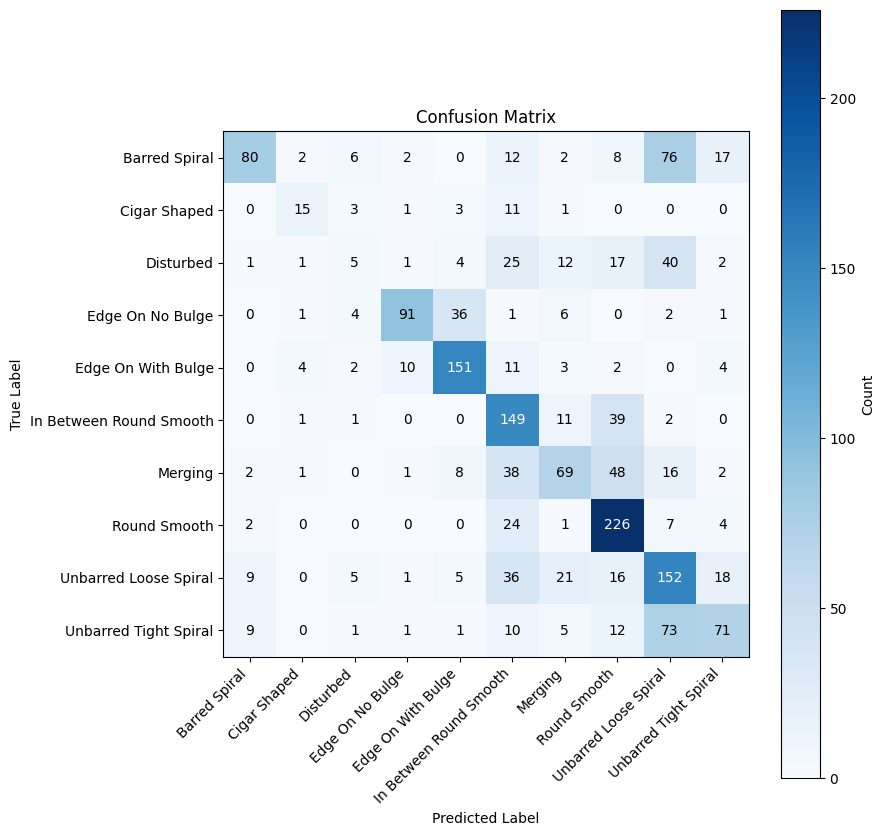

In [29]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## Custom CNN

In [6]:
custom_model = custom_cnn(num_classes=10).to(device)

In [7]:
from torchinfo import summary

summary(
    custom_model,
    input_size=(1, 3, 224, 224)
)

Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 512, 222, 222]        14,336
│    └─ReLU: 2-2                         [1, 512, 222, 222]        --
│    └─MaxPool2d: 2-3                    [1, 512, 111, 111]        --
│    └─Conv2d: 2-4                       [1, 256, 109, 109]        1,179,904
│    └─ReLU: 2-5                         [1, 256, 109, 109]        --
│    └─MaxPool2d: 2-6                    [1, 256, 54, 54]          --
│    └─Conv2d: 2-7                       [1, 128, 52, 52]          295,040
│    └─ReLU: 2-8                         [1, 128, 52, 52]          --
│    └─MaxPool2d: 2-9                    [1, 128, 26, 26]          --
│    └─Conv2d: 2-10                      [1, 128, 24, 24]          147,584
│    └─ReLU: 2-11                        [1, 128, 24, 24]       

In [8]:
train_dir = "../data/Galaxy10_DECaLS/train"
val_dir = "../data/Galaxy10_DECaLS/val"
test_dir = "../data/Galaxy10_DECaLS/test"

train_loader, val_loader, test_loader, class_names= create_dataloaders(train_dir=train_dir, 
                                                                        test_dir=test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=20,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=get_eval_transforms(resize_size=256,crop_size=224),
                                                                        batch_size=16)

In [9]:
optimizer = torch.optim.Adam(params=custom_model.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
early_stopper = EarlyStopping(
    patience=10,
    min_delta=0.001
)

In [11]:
custom_model_results, best_epoch = train(model=custom_model,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=train_loader,
                                test_dataloader=val_loader,
                                validation=True,
                                early_stopping=early_stopper)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8487 | train_acc: 0.2943 | val_loss: 1.5422 | val_acc: 0.3980
Epoch: 2 | train_loss: 1.5403 | train_acc: 0.4102 | val_loss: 1.3622 | val_acc: 0.4583
Epoch: 3 | train_loss: 1.3858 | train_acc: 0.4853 | val_loss: 1.3053 | val_acc: 0.5163
Epoch: 4 | train_loss: 1.2649 | train_acc: 0.5362 | val_loss: 1.2179 | val_acc: 0.5462
Epoch: 5 | train_loss: 1.1900 | train_acc: 0.5720 | val_loss: 1.0987 | val_acc: 0.6156
Epoch: 6 | train_loss: 1.1457 | train_acc: 0.5922 | val_loss: 0.9745 | val_acc: 0.6499
Epoch: 7 | train_loss: 1.0481 | train_acc: 0.6323 | val_loss: 0.9937 | val_acc: 0.6556
Epoch: 8 | train_loss: 1.0062 | train_acc: 0.6477 | val_loss: 0.9747 | val_acc: 0.6511
Epoch: 9 | train_loss: 0.9593 | train_acc: 0.6686 | val_loss: 0.8372 | val_acc: 0.7080
Epoch: 10 | train_loss: 0.9326 | train_acc: 0.6775 | val_loss: 0.8898 | val_acc: 0.6939
Epoch: 11 | train_loss: 0.9156 | train_acc: 0.6865 | val_loss: 0.9811 | val_acc: 0.6832
Epoch: 12 | train_loss: 0.8857 | train_ac

In [12]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 25 epochs


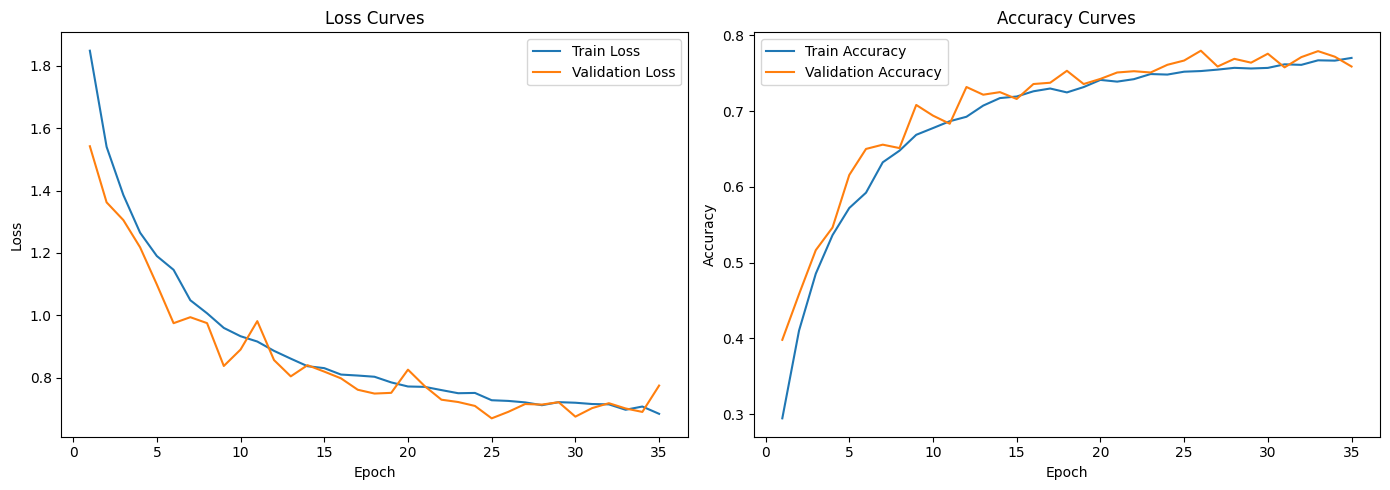

In [13]:
plot_acc_loss_curves(results=custom_model_results,validation=True)

In [15]:
save_model(model=custom_model,model_name=f"CustomCNN_{best_epoch}_epochs_early_stopping.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/custom_cnn/CustomCNN_25_epochs_early_stopping.pth


In [16]:
test_results = test_model(model=custom_model,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.7514
Test loss : 0.8144


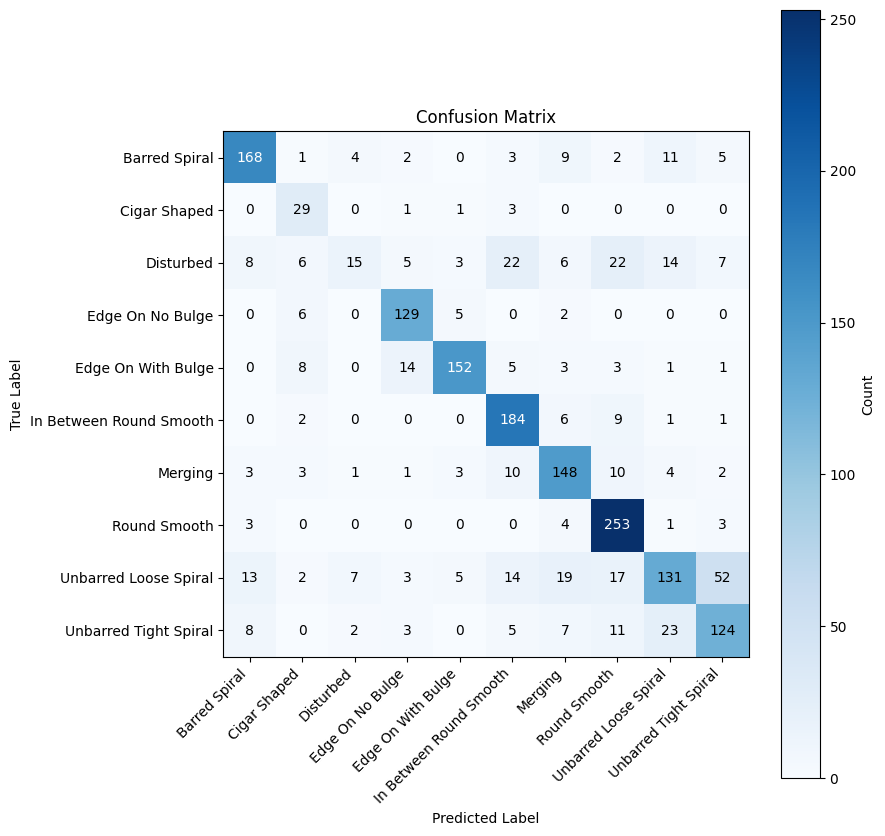

In [17]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Training Custom CNN on balanced dataset

In [21]:
custom_model = custom_cnn(num_classes=10).to(device)
optimizer = torch.optim.Adam(params=custom_model.parameters(),lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss().to(device=device)

In [22]:
early_stopper = EarlyStopping(
    patience=15,
    min_delta=0.001
)

In [24]:
#Balanced dataset
balanced_train_dir = "../data/Galaxy10_DECaLS_Balanced/train"
balanced_test_dir = "../data/Galaxy10_DECaLS_Balanced/test"
val_dir = "../data/Galaxy10_DECaLS/val" #We're not going to use this in our balanced dataset pipeline

balanced_train_loader, _, balanced_test_loader, class_names= create_dataloaders(train_dir=balanced_train_dir, 
                                                                        test_dir=balanced_test_dir,
                                                                        val_dir=val_dir,
                                                                        num_workers=24,
                                                                        train_transform=get_train_transforms(resize_size=256,crop_size=224),
                                                                        eval_transform=get_eval_transforms(resize_size=256,crop_size=224),
                                                                        batch_size=16)

In [25]:
custom_model_results, best_epoch = train(model=custom_model,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=EPOCHS*3,
                                train_dataloader=balanced_train_loader,
                                test_dataloader=balanced_test_loader,
                                validation=False,
                                early_stopping=early_stopper)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2234 | train_acc: 0.1336 | test_loss: 2.0481 | test_acc: 0.1773
Epoch: 2 | train_loss: 1.9873 | train_acc: 0.2384 | test_loss: 1.8988 | test_acc: 0.2424
Epoch: 3 | train_loss: 1.8711 | train_acc: 0.2593 | test_loss: 1.9551 | test_acc: 0.2636
Epoch: 4 | train_loss: 1.7802 | train_acc: 0.3030 | test_loss: 1.7851 | test_acc: 0.3045
Epoch: 5 | train_loss: 1.6901 | train_acc: 0.3466 | test_loss: 1.5870 | test_acc: 0.3606
Epoch: 6 | train_loss: 1.6143 | train_acc: 0.3735 | test_loss: 1.5508 | test_acc: 0.4076
Epoch: 7 | train_loss: 1.5472 | train_acc: 0.4086 | test_loss: 1.5466 | test_acc: 0.4076
Epoch: 8 | train_loss: 1.5289 | train_acc: 0.4190 | test_loss: 1.5247 | test_acc: 0.4667
Epoch: 9 | train_loss: 1.4332 | train_acc: 0.4713 | test_loss: 1.4432 | test_acc: 0.4591
Epoch: 10 | train_loss: 1.4388 | train_acc: 0.4601 | test_loss: 1.4372 | test_acc: 0.4682
Epoch: 11 | train_loss: 1.3855 | train_acc: 0.4784 | test_loss: 1.3665 | test_acc: 0.5045
Epoch: 12 | train_l

In [26]:
print(f"The model stopped improving after {best_epoch} epochs")

The model stopped improving after 40 epochs


In [28]:
save_model(model=custom_model,model_name=f"CustomCNN_{best_epoch}_epochs_early_stopping_balanced_dataset.pth",base_dir='checkpoints')

[INFO] Saving model to: ../checkpoints/custom_cnn/CustomCNN_40_epochs_early_stopping_balanced_dataset.pth


<br>

#### Evaluating on balanced test dataset

In [29]:
balanced_test_results = test_model(model=custom_model,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.5924
Test loss : 1.1362


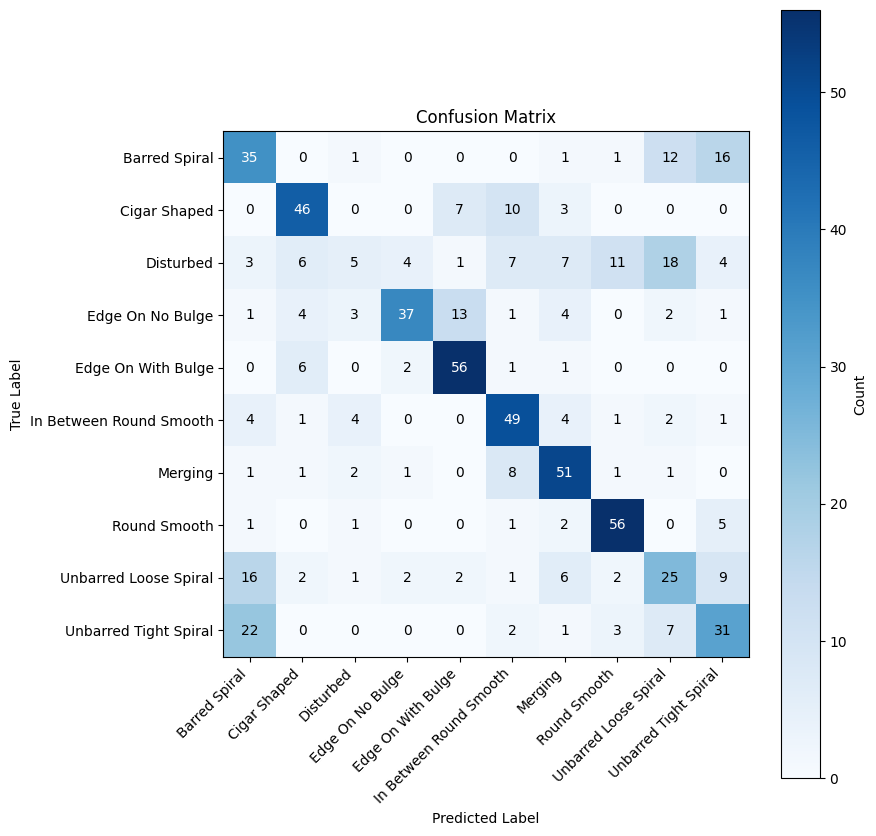

In [30]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>

#### Evaluating on unbalanced test dataset

In [31]:
test_results = test_model(model=custom_model,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.6240
Test loss : 1.0804


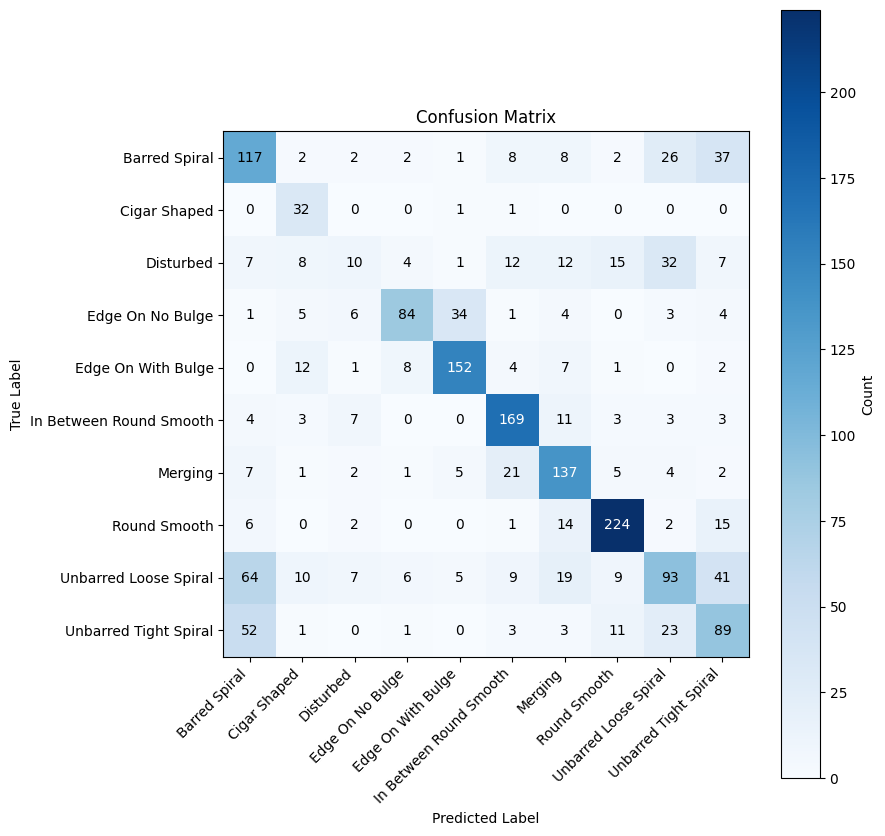

In [32]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=class_names,
                                  normalize=False)

<br>
<br>
<br>

## ViT

In [5]:
DATA_DIR = "../data/Galaxy10_DECaLS"
CLASS_NAMES = [
    "disturbed",
    "merging",
    "round_smooth",
    "in_between_round_smooth",
    "cigar_shaped",
    "barred_spiral",
    "unbarred_tight_spiral",
    "unbarred_loose_spiral",
    "edge_on_no_bulge",
    "edge_on_with_bulge"
]

IMAGE_SIZE = 200
PATCH_SIZE = 25
BATCH_SIZE = 16


In [6]:
config = {
    "patch_size": 25,
    "num_channels": 3,
    "num_patches": 64,          
    "hidden_dim": 256,
    "num_heads": 8,
    "mlp_dim": 1024,
    "num_layers": 6,
    "dropout_rate": 0.1,
    "num_classes": 10,
}

In [ ]:
ViT = VisionTransformer(config).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ViT.parameters(),lr=5e-5,weight_decay=1e-4) #ViTs are sensitive to weight decay. This matches transformer best practice


In [8]:
early_stopping = EarlyStopping(
    patience=20,
    min_delta=1e-4
)

In [9]:
train_loader, val_loader, test_loader = dataloader_vit(
    data_dir=DATA_DIR,
    class_names=CLASS_NAMES,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    batch_size=BATCH_SIZE,
    train_transform=get_vit_train_transform(image_size=IMAGE_SIZE),
    eval_transform=get_vit_eval_transform(image_size=IMAGE_SIZE),
    validation=True,
    num_workers=NUM_WORKERS
)


In [11]:
results, best_epoch = train_vit(
    model=ViT,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=150,
    device=device,
    early_stopping=early_stopping,
    checkpoint_path="../checkpoints/vit/vit_best.pth",
    verbose=True,
    validation=True
)

Training ViT:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001 | train_loss: 1.8248 | train_acc: 0.3230 | val_loss: 1.3928 | val_acc: 0.5039
Epoch 002 | train_loss: 1.2863 | train_acc: 0.5412 | val_loss: 1.1890 | val_acc: 0.5682
Epoch 003 | train_loss: 1.1446 | train_acc: 0.5921 | val_loss: 1.1167 | val_acc: 0.6015
Epoch 004 | train_loss: 1.0832 | train_acc: 0.6144 | val_loss: 1.0579 | val_acc: 0.6308
Epoch 005 | train_loss: 1.0433 | train_acc: 0.6295 | val_loss: 1.0239 | val_acc: 0.6302
Epoch 006 | train_loss: 1.0066 | train_acc: 0.6393 | val_loss: 0.9667 | val_acc: 0.6567
Epoch 007 | train_loss: 0.9757 | train_acc: 0.6534 | val_loss: 0.9951 | val_acc: 0.6499
Epoch 008 | train_loss: 0.9424 | train_acc: 0.6682 | val_loss: 0.9279 | val_acc: 0.6736
Epoch 009 | train_loss: 0.9112 | train_acc: 0.6756 | val_loss: 0.8931 | val_acc: 0.6962
Epoch 010 | train_loss: 0.8940 | train_acc: 0.6864 | val_loss: 0.9344 | val_acc: 0.6736
Epoch 011 | train_loss: 0.8667 | train_acc: 0.6918 | val_loss: 0.8678 | val_acc: 0.6967
Epoch 012 | train_loss: 0.8496 |

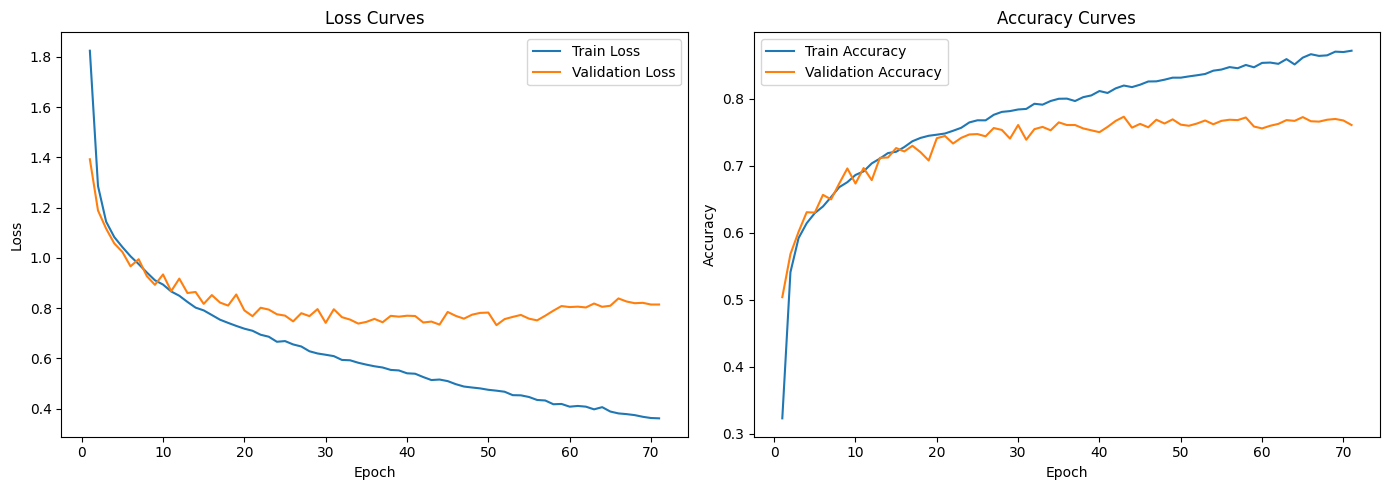

In [12]:
plot_acc_loss_curves(results=results,validation=True)

In [15]:
test_results = test_model(model=ViT,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.7638
Test loss : 0.7343


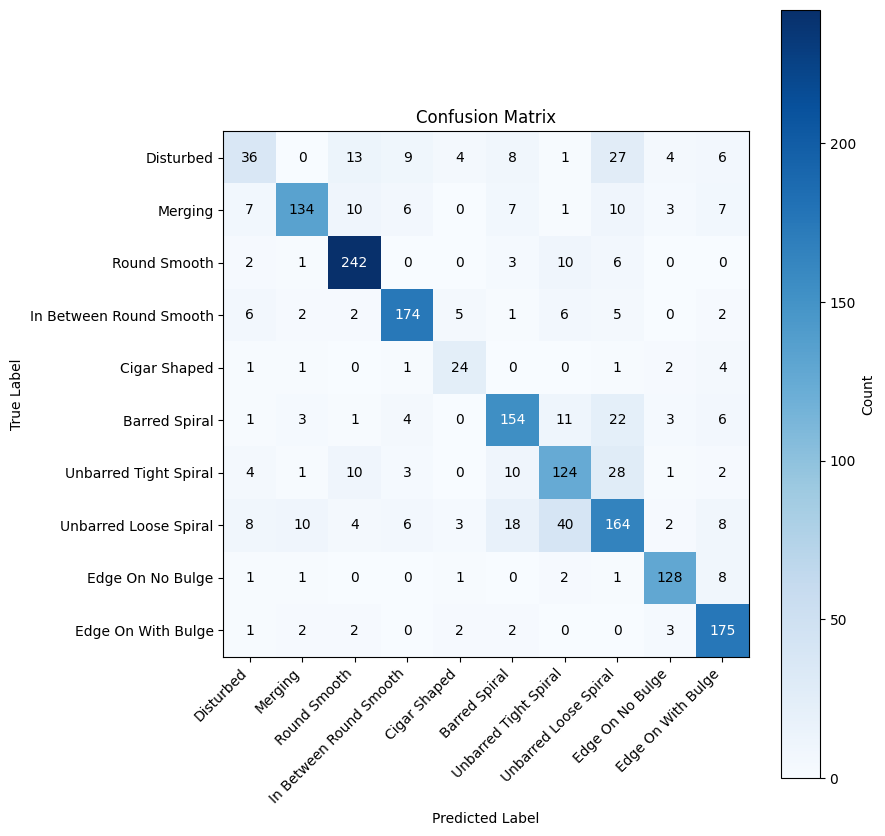

In [17]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=CLASS_NAMES,
                                  normalize=False)

<br>

### Training ViT on balanced dataset

In [20]:
ViT = VisionTransformer(config).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ViT.parameters(),lr=5e-5,weight_decay=1e-4) #ViTs are sensitive to weight decay. This matches transformer best practice

In [21]:
early_stopping = EarlyStopping(
    patience=20,
    min_delta=1e-4
)

In [22]:
DATA_DIR = Path("../data/Galaxy10_DECaLS_Balanced")

balanced_train_loader, balanced_test_loader = dataloader_vit(
    data_dir=DATA_DIR,
    class_names=CLASS_NAMES,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    batch_size=BATCH_SIZE,
    train_transform=get_vit_train_transform(image_size=IMAGE_SIZE),
    eval_transform=get_vit_eval_transform(image_size=IMAGE_SIZE),
    validation=False,
    num_workers=NUM_WORKERS
)

In [23]:
results, best_epoch = train_vit(
    model=ViT,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=300,
    device=device,
    early_stopping=early_stopping,
    checkpoint_path="../checkpoints/vit/vit_best_balanced_dataset.pth",
    verbose=True,
    validation=False
)

Training ViT:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001 | train_loss: 1.8667 | train_acc: 0.3146 | test_loss: 1.3858 | test_acc: 0.5124
Epoch 002 | train_loss: 1.2864 | train_acc: 0.5417 | test_loss: 1.2177 | test_acc: 0.5620
Epoch 003 | train_loss: 1.1422 | train_acc: 0.5963 | test_loss: 1.0714 | test_acc: 0.6184
Epoch 004 | train_loss: 1.0819 | train_acc: 0.6166 | test_loss: 1.0920 | test_acc: 0.6201
Epoch 005 | train_loss: 1.0452 | train_acc: 0.6222 | test_loss: 0.9946 | test_acc: 0.6432
Epoch 006 | train_loss: 1.0009 | train_acc: 0.6470 | test_loss: 0.9926 | test_acc: 0.6601
Epoch 007 | train_loss: 0.9671 | train_acc: 0.6626 | test_loss: 0.9957 | test_acc: 0.6387
Epoch 008 | train_loss: 0.9460 | train_acc: 0.6647 | test_loss: 0.9120 | test_acc: 0.6849
Epoch 009 | train_loss: 0.9144 | train_acc: 0.6773 | test_loss: 0.9269 | test_acc: 0.6759
Epoch 010 | train_loss: 0.8867 | train_acc: 0.6825 | test_loss: 0.8811 | test_acc: 0.6967
Epoch 011 | train_loss: 0.8640 | train_acc: 0.6978 | test_loss: 0.8510 | test_acc: 0.7159
Epoch 012 

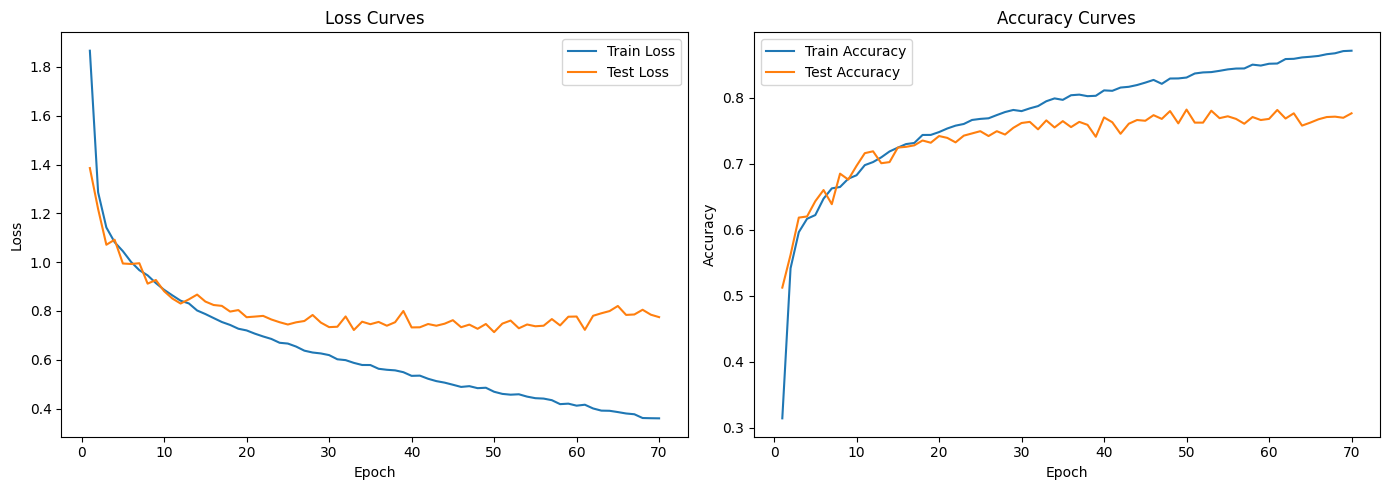

In [25]:
plot_acc_loss_curves(results=results,validation=False)

<br>

#### Evaluating on balanced test dataset

In [26]:
balanced_test_results = test_model(model=ViT,
                       test_dataloader=balanced_test_loader,
                       device=device)

print(f"Test accuracy : {balanced_test_results["test_accuracy"]:.4f}")
print(f"Test loss : {balanced_test_results["test_loss"]:.4f}")

Test accuracy : 0.7485
Test loss : 0.8747


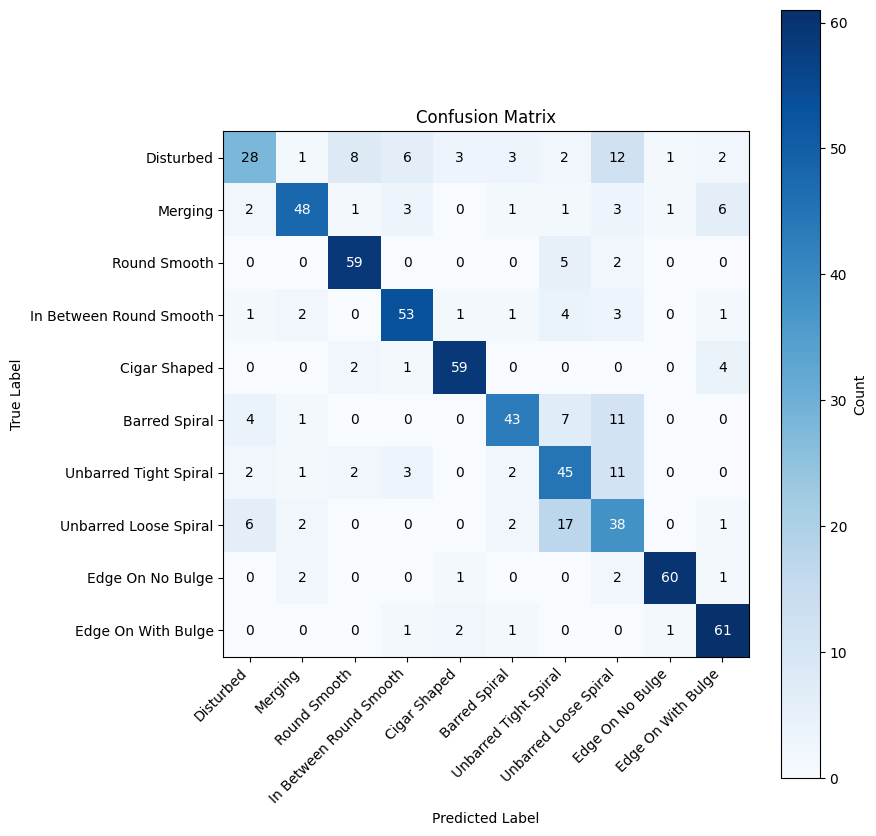

In [27]:
plot_confusion_matrix(labels=balanced_test_results["labels"],
                                  predictions=balanced_test_results["predictions"],
                                  class_names=CLASS_NAMES,
                                  normalize=False)

<br>

#### Evaluating on unbalanced test dataset

In [28]:
test_results = test_model(model=ViT,
                       test_dataloader=test_loader,
                       device=device)

print(f"Test accuracy : {test_results["test_accuracy"]:.4f}")
print(f"Test loss : {test_results["test_loss"]:.4f}")

Test accuracy : 0.7717
Test loss : 0.7687


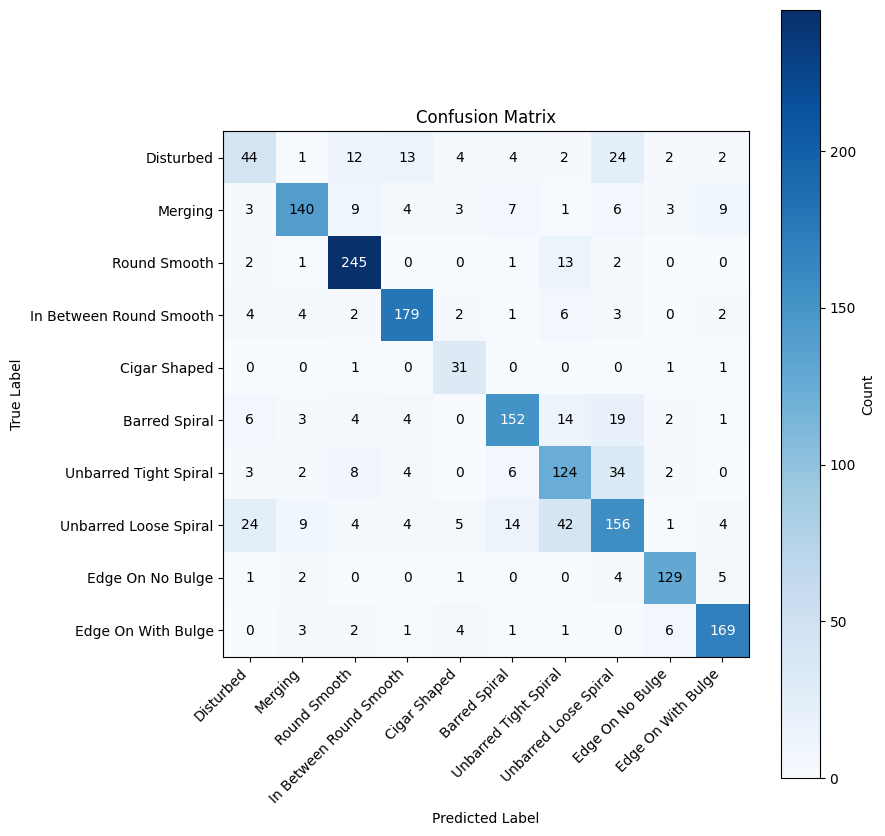

In [29]:
plot_confusion_matrix(labels=test_results["labels"],
                                  predictions=test_results["predictions"],
                                  class_names=CLASS_NAMES,
                                  normalize=False)